In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
from IPython.display import display, HTML, display_html
import matplotlib.lines as mlines
import os
import glob
import numpy as np
from scipy import interpolate

## Plot style sheet

In [2]:
CODE_NAMES  = ['artis', 'artisnebular', 'cmfgen', 'crab', 'kepler', 'sedona', 'stella', 'sumo', 'supernu', 'tardis', 'urilight']
SPECTRAL_CODES  = ['artis', 'artisnebular', 'cmfgen', 'sedona', 'stella', 'sumo', 'supernu', 'tardis', 'urilight']

# code names in figure legends
CODE_LABELS = dict(zip(CODE_NAMES, [code.upper() for code in CODE_NAMES]))
CODE_LABELS['artisnebular'] = CODE_LABELS['artis']
CODE_LABELS['kepler0p1'] = CODE_LABELS['kepler']
CODE_LABELS['kepler0p03'] = CODE_LABELS['kepler']
CODE_LABELS['stella_fr600'] = CODE_LABELS['stella']
CODE_LABELS['supernu'] = 'SuperNu'

# color scheme
# see https://personal.sron.nl/~pault/#sec:qualitative
CODE_COLORS = {
    'artis':'#332288',
    'cmfgen':'#88CCEE',
    'crab':'#44AA99',
    'kepler':'#117733', 
    'sedona':'#999933',
    'stella':'#DDCC77',
    'sumo':'#661100',
    'supernu':'#CC6677',
    'tardis':'#882255',
    'urilight':'#AA4499',
}
CODE_COLORS['artisnebular'] = CODE_COLORS['artis']
CODE_COLORS['kepler0p1'] = CODE_COLORS['kepler']
CODE_COLORS['kepler0p03'] = CODE_COLORS['kepler']
CODE_COLORS['stella_fr600'] = CODE_COLORS['stella']

MODEL_COLORS = {
    'toy06':'#4477AA',
    'toy01':'#CC6677',
    'ddc10':'#DDCC77',
    'ddc25':'#117733'
}

# line styles
CODE_LINE_STYLE = {
    'artis':'-', 
    'cmfgen':'-',
    'crab':'-',
    'kepler':'-',
    'sedona':'-',
    'stella':'-',
    'sumo':'-',
    'supernu':'-',
    'urilight':'-',
    'tardis':'--'
}
CODE_LINE_STYLE['artisnebular'] = CODE_LINE_STYLE['artis']
CODE_LINE_STYLE['kepler0p1'] = CODE_LINE_STYLE['kepler']
CODE_LINE_STYLE['kepler0p03'] = CODE_LINE_STYLE['kepler']
CODE_LINE_STYLE['stella_fr600'] = CODE_LINE_STYLE['stella']

# symbols
CODE_SYMBOLS = {
    'artis': 'x', 
    'cmfgen': 'o', 
    'crab':'<', 
    'kepler':'p', 
    'stella': 'D', 
    'sedona': 'v', 
    'supernu': '*', 
    'urilight': '^', 
    'sumo': 's', 
    'tardis': '1'
}
CODE_SYMBOLS['artisnebular'] = CODE_SYMBOLS['artis']
CODE_SYMBOLS['stella_fr600'] = CODE_SYMBOLS['stella']
CODE_SYMBOLS['kepler0p1'] = CODE_SYMBOLS['kepler']
CODE_SYMBOLS['kepler0p03'] = CODE_SYMBOLS['kepler']

MODEL_NAMES  = ['toy06', 'toy01', 'ddc10', 'ddc25']
MODEL_LABELS = dict(zip(MODEL_NAMES, [model for model in MODEL_NAMES]))
MODEL_LABELS['ddc10'] = 'DDC10'
MODEL_LABELS['ddc25'] = 'DDC25'

BANDS = ['U', 'B', 'V', 'R', 'I', 'J', 'H', 'K']

plt.rc('text', usetex=True)
plt.rc('font', family='serif', serif='Times New Roman', size=10) # define absolute font size here...
plt.rc('xtick', labelsize='small') # ... relative font sizes thereafter
plt.rc('ytick', labelsize='small')
plt.rc('legend', fontsize='medium')

plt.rc('xtick', top=True, direction='in')
plt.rc('xtick.minor', visible=True)
plt.rc('ytick', right=True, direction='in')
plt.rc('ytick.minor', visible=True)

In [3]:
display(HTML('<SPAN STYLE="color: red; font-size: 20pt">&#9888; Set /path/to/local/data1/ directory!</SPAN>'))

#path = './'
path = '/home/sblondin/git/repos/data1/'

## Spectra to Magnitudes conversion (for generating magnitudes only)

Run the following code in a conda environment where wsynphot and starkit packages are installed along with their dependencies. To create such environment, you can run following commands in your terminal:

```bash
curl -O https://raw.githubusercontent.com/starkit/starkit/master/starkit_env3.yml
conda env create --file starkit_env3.yml -n starkit
conda activate starkit
git clone https://github.com/starkit/starkit && cd starkit && python setup.py develop
cd ..
git clone https://github.com/starkit/wsynphot && cd wsynphot && python setup.py develop
```

In [ ]:
import wsynphot
from starkit.fix_spectrum1d import SKSpectrum1D
import astropy.units as u

In [ ]:
FILTERS = {
    "U": "Generic/Bessell/U",
    "B": "Generic/Bessell/B",
    "V": "Generic/Bessell/V",
    "R": "Generic/Bessell/R",
    "I": "Generic/Bessell/I",
    "J": "2MASS/2MASS/J",
    "H": "2MASS/2MASS/H",
    "K": "2MASS/2MASS/Ks",
}

FILTER_NAMES = list(FILTERS.keys())
FILTER_IDS_LIST = list(FILTERS.values())


In [ ]:
# Download filters data (1st time only)
wsynphot.download_filter_data(FILTER_IDS_LIST)

In [ ]:
# Download calibration data (1st time only)
!curl -O https://archive.stsci.edu/hlsps/reference-atlases/cdbs/calspec/alpha_lyr_stis_003.fits

In [ ]:
# Magnitude calculation functions

def calculate_spectrum_magnitudes(
    wavelength, flux, filters_list=FILTER_IDS_LIST
):
    """
    Calculate photometric magnitudes of a spectrum for a list of filters

    Parameters
    ----------
    wavelength : astropy.Quantity
        In Angstroms (u.AA)
    flux : astropy.Quantity
        In erg/s/AA/(cm**2)
    filter_list : list of str, optional
        SVO Filter IDs to let wsynphot identify what filters to use.
        By default FILTER_IDS_LIST

    Returns
    -------
    list of float
    Magnitude for the list of filters
    """
    spectrum = SKSpectrum1D.from_array(wavelength, flux)
    filters = wsynphot.FilterSet(
        filters_list,
        interpolation_kind="cubic",
        vega_fpath="alpha_lyr_stis_003.fits",
    )

    phot_values = filters.calculate_vega_magnitudes(spectrum)
    return [v.value for v in phot_values]

def to_flux(lum):
    """
    Convert luminosity to flux for a distance of 10 parsec

    Parameters
    ----------
    lum : pd.Series
        Luminosity

    Returns
    -------
    astropy.Quantity
        Flux in erg/s/AA/(cm**2)
    """
    luminosity = lum.to_numpy() * (u.erg / u.s / u.AA)
    area = 4.0 * np.pi * ((10 * u.pc).to("cm")) ** 2
    flux = luminosity / area
    return flux

def calculate_magnitudes_df(spectra_df):
    spectra_df.sort_values('wavelength', inplace=True)
    wavelength = spectra_df.wavelength.to_numpy() * u.AA

    magnitudes = (
        spectra_df.iloc[:, 1:]
        .apply(
            lambda lum: pd.Series(
                calculate_spectrum_magnitudes(wavelength, to_flux(lum)),
                index=FILTER_NAMES,
            ),
            axis=0,  # apply on each column
        )
        .T
    )

    magnitudes.index.name = "time"
    return magnitudes

def write_magnitudes(magnitudes_df, fpath):
    mag = magnitudes_df.reset_index()
    mag['time'] = mag['time'].map(lambda x: '{0:e}'.format(x))
    mag.to_csv(
        fpath,
        sep=" ",
        encoding='utf-8',
        index=False,
        float_format="%.6f",
    )


In [ ]:
## Reading the spectral data

#CODE_NAMES = ['artis', 'cmfgen', 'sedona', 'stella', 'supernu', 'urilight']


def read_spectrum(fname):
    col_names = ['wavelength']
    with open(fname, encoding='utf8') as fh:
        for i, line in enumerate(fh):
            if i==2:
                times = list(map(np.float64, line.strip().split(':')[1].split()))
    
    spectrum = pd.read_csv(fname, delim_whitespace=True, comment='#', header=None)
    spectrum.columns = col_names + times
    return spectrum


spectral_data = {}
for model in MODEL_NAMES:
    spectral_data[model] = {}
    for code_name in SPECTRAL_CODES:
        fname = '{2}/{1}/spectra_{1}_{0}.txt'.format(code_name, model, path)
        if not os.path.exists(fname):
            continue
        try:
            spectral_data[model][code_name] = read_spectrum(fname)
        except UnicodeDecodeError:
            print('File {0} does raise a UnicodeDecodeError'.format(fname))
            pass
        except IndexError:
            print('File {0} does raise a IndexError'.format(fname))
            pass
        except ValueError:
            print('File {0} does raise a ValueError'.format(fname))
            pass

In [ ]:
# Converting spectral data to magnitudes data

mag_data = {}
for model in MODEL_NAMES:
    mag_data[model] = {}
    for code_name in SPECTRAL_CODES:
        try:
            spec = spectral_data[model][code_name]
        except KeyError:
            print(
                "spectra_{1}_{0} isn't available".format(
                    code_name, model
                )
            )
            continue

        print(
            "Calculating magnitudes for spectra_{1}_{0}.txt ...".format(
                code_name, model
            )
        )
        mag_data[model][code_name] = calculate_magnitudes_df(spec).reset_index()
        
        # Save magnitudes to file
        # mags_fpath = "../data1/{1}/wsynphot_mags_{1}_{0}.txt".format(
        #     code_name, model
        # )
        # write_magnitudes(calculate_magnitudes_df(spec), mags_fpath)

print("DONE!")

In [ ]:
mag_data['toy01']['supernu']

## Read magnitudes from file

In [4]:
def read_mags(file, checkformat=False):

    '''
wsynphot_mags_<model>_<code>.txt file format:

#<optional header lines>
#NTIMES: int
#NBANDS: int
#time[d] <filtername_1> <filtername_2> ... <filtername_NBANDS>
float float float ... float
    '''

    print('INFO - reading file ' + file)
    
    with open(file, 'r') as f:
        
        ### perform a strict test of the file format
        if checkformat:
            okfmt = 0
            iline = 0
            while okfmt == 0:
                line = f.readline()
                iline += 1
                if line[0] != '#':
                    print('ERROR - header lines should start with "#" (line {:d})'.format(iline))
                    print(' line {:d}: "{:s}"'.format(iline, line.rstrip()))
                    sys.exit(read_mags.__doc__)
                elif 'NTIMES' in line:
                    if line[:8] != '#NTIMES:':
                        print('ERROR - conflicting header line (line {:d})'.format(iline))
                        print(' line {:d}: "{:s}"'.format(iline, line.rstrip()))
                        print(' expecting "#NTIMES: int"')
                        sys.exit(read_mags.__doc__)
                    else:
                        try:
                            nt = int(line.split()[1])
                            ncols = nt + 1
                        except ValueError:
                            print('ERROR - conflicting header line (line {:d})'.format(iline))
                            print(' line {:d}: "{:s}"'.format(iline, line.rstrip()))
                            print(' expecting "#NTIMES: int"')
                            sys.exit(read_mags.__doc__)
                    line = f.readline()
                    iline += 1
                    if line[:8] != '#NBANDS:':
                        print('ERROR - conflicting header line (line {:d})'.format(iline))
                        print(' line {:d}: "{:s}"'.format(iline, line.rstrip()))
                        print(' expecting "#NBANDS: int"')
                        sys.exit(read_mags.__doc__)
                    else:
                        try:
                            nbands = int(line.split()[1])
                            ncols = nbands + 1
                        except ValueError:
                            print('ERROR - conflicting header line (line {:d})'.format(iline))
                            print(' line {:d}: "{:s}"'.format(iline, line.rstrip()))
                            print(' expecting "#NBANDS: int"')
                            sys.exit(read_mags.__doc__)
                    line = f.readline()
                    iline += 1
                    if line[:8] != '#time[d]' or len(line.split()) != ncols:
                        print('ERROR - conflicting header line (line {:d})'.format(iline))
                        print(' line {:d}: "{:s}"'.format(iline, line.rstrip()))
                        print(' expecting "#time[d] followed by NBANDS={:d} filter names"'.format(nbands))
                        sys.exit(read_mags.__doc__)
                    else:
                        bands = line.split()[1:]
                        print('INFO - header conforms to standard. Will now check numerical content')
                        for i in range(nt):
                            line = f.readline()
                            iline += 1
                            if not line:
                                print('ERROR - format check FAILED. EOF reached (line {:d})'.format(iline))
                                print(' line {:d}: "{:s}"'.format(iline, line.rstrip()))
                                print(' ===> check NTIMES={:d} value in header'.format(nt))
                                sys.exit(read_mags.__doc__)
                            elif len(line.rstrip()) == 0:
                                print('ERROR - format check FAILED. Empty line (line {:d})'.format(iline))
                                print(' line {:d}: "{:s}"'.format(iline, line.rstrip()))
                                sys.exit(read_mags.__doc__)
                            elif len(line.split()) != ncols:
                                print('ERROR - format check FAILED. File contains {:d} instead of {:d} columns (line {:d})'.format(len(line.split()), ncols, iline))
                                print(' line {:d}: "{:s}"'.format(iline, line.rstrip()))
                                print(' expecting NBANDS+1={:d} columns'.format(ncols))
                                sys.exit(read_mags.__doc__)
                            isfinite = [np.isfinite(float(line.split()[ii])) for ii in range(ncols)]
                            if False in isfinite:
                                print('ERROR - non-finite numerical values (line {:d})'.format(iline))
                                print(' line {:d}: "{:s}"'.format(iline, line.rstrip()))
                                print(' expecting "float float float ... float"')
                                sys.exit(read_mags.__doc__)
                        # check there are no lines left
                        line = f.readline()
                        iline += 1
                        if line:
                            print('ERROR - lines remaining after NTIMES={:d} lines read (line {:d})'.format(nt, iline))
                            print(' line {:d}: "{:s}"'.format(iline, line.rstrip()))
                            print(' ===> check NTIMES={:d} value in header'.format(nt))
                            sys.exit(read_mags.__doc__)
                        else:
                            print('INFO - format check OK!')
                            okfmt = 1

        # no strict format check
        else:
                            
            ### read in header
            okhdr = 0
            while okhdr == 0:
                line = f.readline()
                if 'NTIMES' in line:
                    nt = int(line.split()[1])
                elif 'NBANDS' in line:
                    nbands = int(line.split()[1])
                elif 'time[d]' in line:
                    split_line = line.split()
                    bands = split_line[1:]
                    okhdr = 1

    ### read numerical data
    vals = np.loadtxt(file)
    time = vals[:,0]
    mag = {b: None for b in bands}
    for ib, b in enumerate(bands):
        mag[b] = vals[:,ib+1]
                        
    # output
    out = {}
    out['time'] = time
    out['bands'] = bands
    out['mag'] = mag
    out['units'] = 'time: days\nbands: N/A\nmag: mag'
    
    return out

In [5]:
mag_data = {}
for model in MODEL_NAMES:
    mag_data[model] = {}
    for code_name in SPECTRAL_CODES:
        if model == 'toy06' and code_name == 'stella':
            codestr = 'stella_fr600'
        else:
            codestr = code_name
        fname = '{2}/{1}/wsynphot_mags_{1}_{0}.txt'.format(codestr, model, path)
        if not os.path.exists(fname):
            continue
        mag_data[model][code_name] = read_mags(fname)
        
        for b in BANDS:
            mag_data[model][code_name][b] = mag_data[model][code_name]['mag'][b]
            
        del mag_data[model][code_name]['mag']

INFO - reading file /home/sblondin/git/repos/data1//toy06/wsynphot_mags_toy06_artis.txt
INFO - reading file /home/sblondin/git/repos/data1//toy06/wsynphot_mags_toy06_artisnebular.txt
INFO - reading file /home/sblondin/git/repos/data1//toy06/wsynphot_mags_toy06_cmfgen.txt
INFO - reading file /home/sblondin/git/repos/data1//toy06/wsynphot_mags_toy06_sedona.txt
INFO - reading file /home/sblondin/git/repos/data1//toy06/wsynphot_mags_toy06_stella_fr600.txt
INFO - reading file /home/sblondin/git/repos/data1//toy06/wsynphot_mags_toy06_sumo.txt
INFO - reading file /home/sblondin/git/repos/data1//toy06/wsynphot_mags_toy06_supernu.txt
INFO - reading file /home/sblondin/git/repos/data1//toy06/wsynphot_mags_toy06_tardis.txt
INFO - reading file /home/sblondin/git/repos/data1//toy06/wsynphot_mags_toy06_urilight.txt
INFO - reading file /home/sblondin/git/repos/data1//toy01/wsynphot_mags_toy01_artisnebular.txt
INFO - reading file /home/sblondin/git/repos/data1//toy01/wsynphot_mags_toy01_cmfgen.txt
INF

In [6]:
for model in MODEL_NAMES:
    for code_name in SPECTRAL_CODES:
        try:
            mag_data[model][code_name]
        except KeyError:
            continue
        plotting_keys = {'time', *mag_data[model][code_name]['bands']}
        mag_data[model][code_name] = pd.DataFrame({key:value for key,value in mag_data[model][code_name].items() if key in plotting_keys})

# Observables

## Light curve parameters 

Light curve parameters such as the peak magnitude, rise time, and $\Delta m_{15}$ are extracted from a polynomial fit:

In [7]:
class LightCurveFitter(object):
    def __init__(self, mags, times, fit_order=6,
                 delta_t=[-7., 20.], t_max_range=[2.5, 30]):
        self.mags = mags
        self.fit_order = fit_order
        self.times = times
        self.delta_t = delta_t
        self.t_max_range = t_max_range
        self.coeffs = self.fit_lightcurve(
            self.times_fit, self.mags_fit, self.fit_order)
    
    @staticmethod
    def fit_lightcurve(time, mags, fit_order=6):
        coeffs = np.polyfit(time, mags, fit_order)
        return coeffs


    @property
    def times_fit(self):
        mask = np.logical_and(self.times > self.t_max_naive + self.delta_t[0],
                              self.times < self.t_max_naive + self.delta_t[1])
        return self.times[mask]
    
    @property
    def mags_fit(self):
        mask = np.logical_and(self.times > self.t_max_naive + self.delta_t[0],
                              self.times < self.t_max_naive + self.delta_t[1])
        return self.mags[mask]
    
    @property
    def t_max_naive(self):
        mask = np.logical_and(self.times > self.t_max_range[0],
                              self.times < self.t_max_range[1])
        times_restricted = self.times[mask].values
        max_index = np.argmin(self.mags.values[mask])
        return times_restricted[max_index]
    
    def mags_fitted(self, times):
        return np.polyval(self.coeffs, times)

    @property
    def t_max(self):
        times = np.linspace(self.times_fit.min(),
                            self.times_fit.max(), 50000)
        mask = np.logical_and(times > self.t_max_range[0],
                              times < self.t_max_range[1])
        times = times[mask]
        mags = self.mags_fitted(times)
        return times[np.argmin(mags)]
    
    @property
    def m_max(self):
        return self.mags_fitted(self.t_max)

    @property
    def m_15(self):
        return self.mags_fitted(self.t_max + 15)
    
    @property
    def delta_m15(self):
        return self.m_15 - self.m_max
    
    def plot_fit(self, times, ax=None, figsize=None):
        if not ax:
            fig = plt.figure(figsize=figsize)
            ax = fig.add_subplot(111)
        ax.scatter(self.times, self.mags, alpha=0.9, marker='.')
        ax.plot(times, self.mags_fitted(times), c='g')
        ax.set_xlim(2, self.times_fit.max() + 15)
        ax.scatter(self.t_max, self.m_max, marker='x', color='red')
        ax.scatter(self.t_max + 15,
                   self.m_max + self.delta_m15,
                   marker='x', color='r')
        ax.set_xlim(times.min(), times.max())
        
        mask_times = np.logical_and(self.times > times.min(),
                                    self.times < times.max())
        mag_plot_min = self.mags[mask_times].max() + 0.4
        mag_plot_max = self.mags[mask_times].min() - 0.4
        ax.set_ylim(mag_plot_min, mag_plot_max)
        ax.vlines([self.times_fit.min(), self.times_fit.max()],
                  mag_plot_min, mag_plot_max)
        ax.set_xlabel('Time [d]')
        return ax


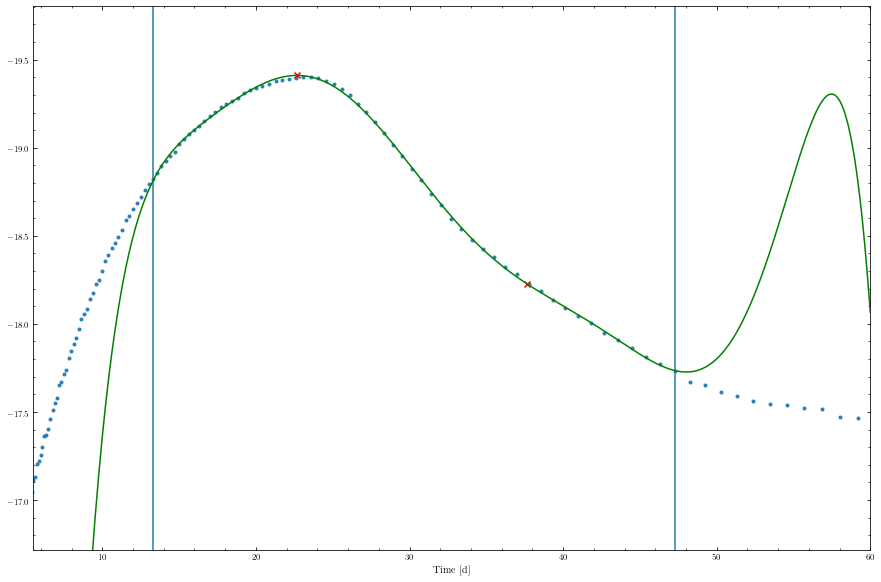

In [8]:
%matplotlib inline
display(HTML('<SPAN STYLE="color: red; font-size: 20pt">&#9888; For internal verification only!</SPAN>'))
lc_data = mag_data['toy06']['artis']
lc_fit = LightCurveFitter(mags=lc_data['V'], times=lc_data['time'], delta_t=[-10, 25], fit_order=8,
                          t_max_range=[10,30])
ax = lc_fit.plot_fit(np.linspace(5.5, 60, 500), figsize=(15,10))

Failed for model=toy06, code=artisnebular.
Failed for model=toy06, code=sumo.


/home/sblondin/anaconda3/envs/starkit/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.


Failed for model=toy01, code=artis.
Failed for model=toy01, code=artisnebular.
Failed for model=toy01, code=sumo.


/home/sblondin/anaconda3/envs/starkit/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.


Failed for model=ddc10, code=artisnebular.
Failed for model=ddc10, code=sumo.


/home/sblondin/anaconda3/envs/starkit/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.


Failed for model=ddc25, code=artis.
Failed for model=ddc25, code=artisnebular.
Failed for model=ddc25, code=sedona.
Failed for model=ddc25, code=sumo.


/home/sblondin/anaconda3/envs/starkit/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.


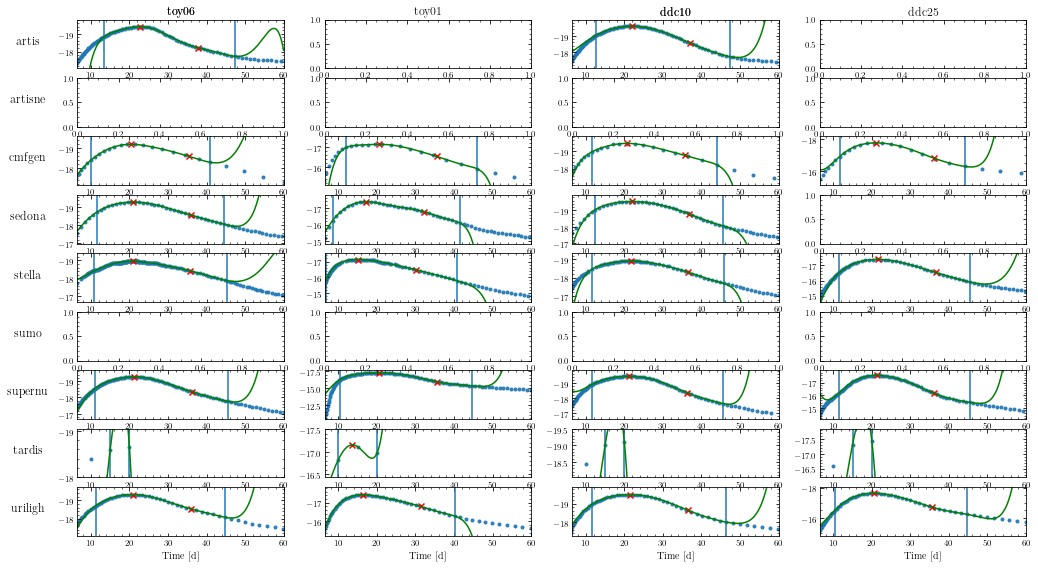

In [9]:
%matplotlib inline
display(HTML('<SPAN STYLE="color: red; font-size: 20pt">&#9888; For internal verification only!</SPAN>'))
band = 'V'
fig, axes = plt.subplots(nrows=len(SPECTRAL_CODES), ncols=len(MODEL_NAMES), figsize=(17.0,9.5))
for i, model in enumerate(MODEL_NAMES):
    for j, code in enumerate(SPECTRAL_CODES):
        try:
            lc_data = mag_data[model][code]
            lc_fit = LightCurveFitter(mags=lc_data[band], times=lc_data['time'],
                                      delta_t=[-10, 25], fit_order=8, 
                                      t_max_range=[10,30])
            ax = lc_fit.plot_fit(np.linspace(6.5, 60, 500), ax=axes[j,i])
            if j == 0:
                if code == "stella_fr600": code = "stella fr600"
                axes[j,i].annotate(model, xy=(0.5, 1), xytext=(0, 5),
                    xycoords='axes fraction', textcoords='offset points',
                    size='large', ha='center', va='baseline')
        except:
            print('Failed for model={}, code={}.'.format(model, code))
        if j == 0:
            axes[j,i].annotate(
                model, xy=(0.5, 1), xytext=(0, 5),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline'
            )
        if i == 0:
            if code == "stella_fr600": code = "stella fr600"
            axes[j,i].annotate(
                code[:7], xy=(0, 0.5), xytext=(-50, 0),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline'
            )

### $\Delta m_{15}$,  $m_B$ (+ Phillips relation)

In [10]:
# Ignore! Only needed for notebook table visualization.
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df
    display_html(
        html_str.replace('table','table style="display:inline"'), raw=True
    )

Fit B-band peak $m_B$ and $\Delta m_{15}$:

In [11]:
#%matplotlib widget
from matplotlib.cm import get_cmap
from IPython.display import HTML

phillips_tables = {}
for model in MODEL_NAMES:
    phillips_tables[model] = pd.DataFrame(
        columns=['m_B', 'delta_m15', 't_max'], index=SPECTRAL_CODES
    )
    for code, lc_data in mag_data[model].items():
        if code in ['artisnebular', 'sumo', 'tardis']:
            # skip codes that are only late-time or do not produce light curves
            continue
        lc_fit = LightCurveFitter(mags=lc_data['B'],
                                  times=lc_data['time'],
                                  delta_t=[-10, 30],
                                  fit_order=8)
        phillips_tables[model].loc[code] = [lc_fit.m_max, lc_fit.delta_m15, lc_fit.t_max]

styled_tables = {}
for model in MODEL_NAMES:
    s = phillips_tables[model].dropna().astype(float)
    styled_tables[model] = s.style.background_gradient(cmap='viridis',
                                                       axis=0).set_caption(model).render()

display_side_by_side(styled_tables['toy01'],
                     styled_tables['toy06'],
                     styled_tables['ddc10'],
                     styled_tables['ddc25'])

,m_B,delta_m15,t_max
cmfgen,-17.2178,0.845859,17.2363
sedona,-17.2052,1.38937,17.4507
stella,-17.121,1.11401,14.5557
supernu,-16.8664,2.03466,19.5069
urilight,-17.3071,1.11295,17.7901
,m_B,delta_m15,t_max
artis,-19.1906,1.73121,19.7193
cmfgen,-19.2823,0.867742,18.1215
sedona,-19.2438,1.25121,19.5039
stella,-19.019,1.11316,17.4606


In [12]:
%matplotlib inline

display(HTML('<SPAN STYLE="color: red; font-size: 20pt">&#9888; For internal discussion only!</SPAN>'))
# Remove Phillips
#sneIa = pd.read_csv('CfA3_Phillips_II.csv')

## Set figsize

In [13]:
# need to include this in cell below
# fig = plt.figure(figsize=(3.32, 2.5))

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


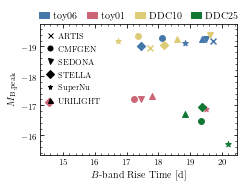

In [14]:
fig = plt.figure(figsize=(3.32, 2.5))
ax = fig.add_subplot(111)
fig.subplots_adjust(left=.15, bottom=.17, right=.975, top=.9)

#ax.errorbar(sneIa.dm15, sneIa.mb, xerr=sneIa.errdm15, yerr=sneIa.errmb,
#            fmt='none', ecolor='black', label='normal Ias', alpha=0.3, zorder=0)
#ax.set_xlabel('$\Delta m_{15}$(B)')

ax.set_xlabel('$B$-band Rise Time [d]')
ax.set_ylabel('$M_{\mathrm{B,peak}}$')
ax.set_xmargin(0.05)
ax.set_ymargin(0.1)

for model in MODEL_NAMES:
    for code, lc_params in phillips_tables[model].iterrows():
        if code in ['artisnebular', 'sumo', 'tardis']:
            # skip codes that are only late-time or do not produce complete light curves
            continue
        ax.scatter(lc_params.t_max, lc_params.m_B, 
                   label=CODE_LABELS[code], color=MODEL_COLORS[model], marker=CODE_SYMBOLS[code], s=35)
        
legend_handles = []
for model in MODEL_NAMES:
    legend_handles.append(mpatches.Patch(color=MODEL_COLORS[model], label=MODEL_LABELS[model]))
model_legend = ax.legend(handles=legend_handles, bbox_to_anchor=[-.05,0,1,1.17], ncol=4,
                          loc='upper left', frameon=False, handlelength=.6, columnspacing=1.)

for patch in model_legend.get_patches():
    patch.set_height(6)
    patch.set_width(10)

code_legend_handles = []
for code in SPECTRAL_CODES:
    if code in ['artisnebular', 'sumo', 'tardis']:
        # skip codes that are only late-time or do not produce complete light curves
        continue
    marker = mlines.Line2D([], [], color='black', marker=CODE_SYMBOLS[code], label=CODE_LABELS[code], lw=0., markersize=5)
    
    # avoid duplicate entries (e.g. for STELLA)    
    if marker.get_label() not in [m.get_label() for m in code_legend_handles]:
        code_legend_handles.append(marker)

code_legend = ax.legend(handles=code_legend_handles, bbox_to_anchor=[0,0,1,1],
                         loc='upper left', frameon=False, fontsize=8, handlelength=.6, )

plt.gca().add_artist(model_legend)
plt.gca().invert_yaxis()

plt.savefig("mBpeak_vs_triseB.pdf")

In [15]:
%matplotlib inline
'''
x-axis: models
y-axis: rise time as bars with color for each code
'''
# Removed Phillips data
#sneIa = pd.read_csv('CfA3_Phillips_II.csv')

'\nx-axis: models\ny-axis: rise time as bars with color for each code\n'

## Set figsize

In [16]:
# need to include this in cell below
#fig = plt.figure(figsize=(6.0,7.5))

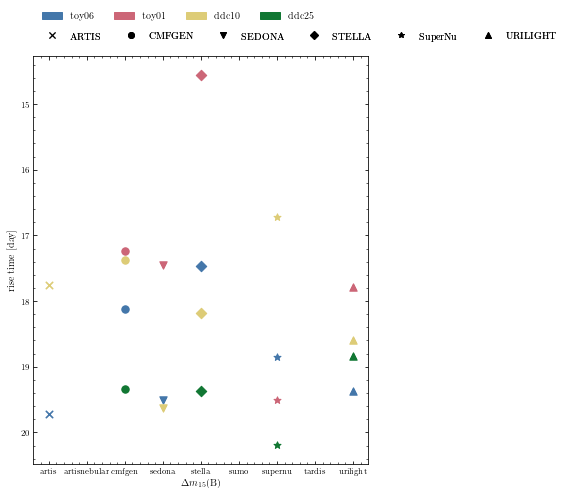

In [17]:
fig = plt.figure(figsize=(6.0,7.5))
ax = fig.add_subplot(111)
#ax.errorbar(sneIa.dm15, sneIa.mb, xerr=sneIa.errdm15, yerr=sneIa.errmb,
#            fmt='none', ecolor='black', label='normal Ias', alpha=0.3, zorder=0)
ax.set_xlabel('$\Delta m_{15}$(B)')
ax.set_ylabel('rise time [day]')
plt.gca().invert_yaxis()
for model in MODEL_NAMES:
    for code, lc_params in phillips_tables[model].iterrows():
        plt.scatter(code, lc_params.t_max,
                    label=CODE_LABELS[code], color=MODEL_COLORS[model], marker=CODE_SYMBOLS[code], s=55)
        plt.plot(code, lc_params.t_max,
                    label=CODE_LABELS[code], color=MODEL_COLORS[model], marker=CODE_SYMBOLS[code])
legend_handles = []
for c, model in zip(MODEL_COLORS, MODEL_LABELS):
    legend_handles.append(mpatches.Patch(color=MODEL_COLORS[model], label=model))
model_legend = plt.legend(handles=legend_handles, bbox_to_anchor=[0., 1.10], ncol=4,
                          loc='center left', frameon=False)

code_legend_handles = []
for code in SPECTRAL_CODES:
    if code in ['artisnebular', 'sumo', 'tardis']:
        # skip codes that are only late-time or do not produce light curves
        continue
    code_legend_handles.append
    marker = mlines.Line2D(
        [], [], color='black', marker=CODE_SYMBOLS[code], label=CODE_LABELS[code], lw=0.)
    code_legend_handles.append(marker)
code_legend = plt.legend(handles=code_legend_handles, bbox_to_anchor=[0., 1.05], ncol=len(CODE_SYMBOLS),
                         loc='center left', frameon=False)
plt.gca().add_artist(code_legend)
plt.gca().add_artist(model_legend)

plt.show()
# fig.savefig("m15_models.pdf")

In [18]:
# %matplotlib inline
# '''
# x-axis: models
# y-axis: rise time as bars with color for each code
# '''

# #sneIa = pd.read_csv('CfA3_Phillips_II.csv')

## Set figsize

In [19]:
# need to include this in cell below
#fig = plt.figure(figsize=(6.0,7.5))

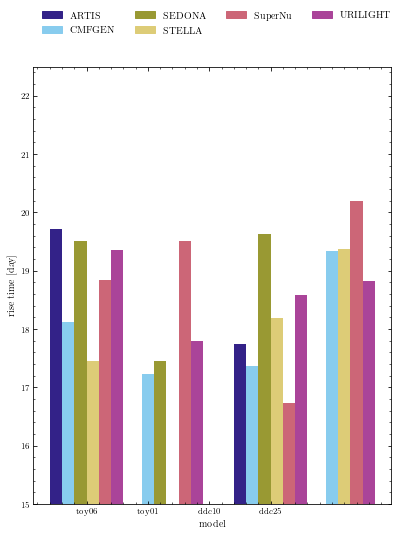

In [20]:
fig = plt.figure(figsize=(6.0,7.5))
ax = fig.add_subplot(111)
ax.set_xlabel('model')
ax.set_ylabel('rise time [day]')
x = 1
for model in MODEL_NAMES:
    dx = -0.5
    for code, lc_params in phillips_tables[model].iterrows():
        if code in ['artisnebular','crab','kepler','sumo','tardis']:
            # skip codes that are only late-time or do not produce light curves
            continue
        plt.bar(x + dx, lc_params.t_max, color = CODE_COLORS[code], width = 0.2)
        if not np.isnan(lc_params.t_max):
            dx += 0.2
    x += 1.5
legend_handles = []
for code in CODE_NAMES:
    if code in ['artisnebular','crab','kepler','sumo','tardis']:
        # skip codes that are only late-time or do not produce light curves
        continue
    legend_handles.append(mpatches.Patch(color=CODE_COLORS[code], label=CODE_LABELS[code]))
model_legend = plt.legend(handles=legend_handles, bbox_to_anchor=[0., 1.10], ncol=4,
                          loc='center left', frameon=False)

# code_legend_handles = []
# for code, symbol in symbols.items():
#     code_legend_handles.append
#     marker = mlines.Line2D(
#         [], [], color='black', marker=symbol, label=code, lw=0.)
#     code_legend_handles.append(marker)
# code_legend = plt.legend(handles=code_legend_handles, bbox_to_anchor=[0., 1.05], ncol=len(symbols),
#                          loc='center left', frameon=False)
# plt.gca().add_artist(code_legend)
# plt.gca().add_artist(model_legend)

labels = MODEL_NAMES
ax.set_xticks(np.arange(1, len(MODEL_NAMES)+1))
ax.set_xticklabels(labels)
ax.set_ylim(15, 22.5)
plt.tight_layout()
plt.show()
# fig.savefig("m15_models_bar.pdf")

### Rise times

In [21]:
bands = ['U', 'B', 'V', 'R'] # For infrared light curves a single rise time is not useful
risetime_tables = {}
for model in MODEL_NAMES:
    risetime_tables[model] = pd.DataFrame(columns=bands, index=SPECTRAL_CODES)
    for band in bands:
        for code in SPECTRAL_CODES:
            try:
                lc_data = mag_data[model][code]
                lc_fit = LightCurveFitter(mags=lc_data[band], times=lc_data.time, delta_t=[-10, 30])
                risetime_tables[model].loc[code, band] = lc_fit.t_max
            except:
                pass

for model in MODEL_NAMES:
    table = risetime_tables[model].astype(float).dropna(axis=0)
    styled_table = table.style.background_gradient(cmap='viridis', axis=0).set_caption(model)
    display(HTML(styled_table.render()))

/home/sblondin/anaconda3/envs/starkit/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/home/sblondin/anaconda3/envs/starkit/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/home/sblondin/anaconda3/envs/starkit/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/home/sblondin/anaconda3/envs/starkit/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/home/sblondin/anaconda3/envs/starkit/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/home/sblondin/anaconda3/envs/stark

,U,B,V,R
artis,15.3058,19.4287,22.0323,19.6717
cmfgen,15.1525,18.1517,20.4972,21.5707
sedona,15.0357,19.5404,20.8261,18.95
stella,15.3585,17.411,20.8866,25.7026
supernu,13.4862,18.4378,20.8959,18.8886
tardis,14.9903,14.6389,17.8076,14.7283
urilight,14.6924,19.1689,20.5723,18.0934


,U,B,V,R
cmfgen,14.8332,16.185,19.4802,16.7103
sedona,2.50004,17.5677,17.3572,17.2896
stella,13.2737,13.4766,14.4301,13.5112
supernu,17.6892,18.6952,19.9147,19.6448
tardis,14.0253,14.3125,14.4073,14.4883
urilight,17.0104,17.3894,16.1773,16.0833


,U,B,V,R
artis,16.9537,17.8109,21.8849,23.4096
cmfgen,15.0423,17.6194,20.5207,19.6857
sedona,15.8951,19.3458,21.8983,19.2668
stella,15.0966,18.21,21.5261,23.5898
supernu,13.5132,16.4348,21.0607,19.4833
tardis,14.6619,17.8203,17.842,17.7644
urilight,14.4929,18.3924,21.3104,19.1751


,U,B,V,R
cmfgen,19.5326,19.4805,21.1511,21.3312
stella,18.0607,19.3187,21.299,22.8873
supernu,19.5157,20.5682,21.435,21.8159
tardis,17.4837,17.8823,17.8812,17.9831
urilight,2.50052,18.959,20.5538,20.7


## Filter light curves

In [22]:
def plot_filter_light_curves(mag_data, model='toy06', t_range=[2.5, 50],
                             mag_range=[-15, -20], bands=BANDS):
    nrows = int(len(bands) / 2)
    
    
    # FIGSIZE
    fig, axes = plt.subplots(
#         nrows=nrows, ncols=2, figsize=(17.0,9.5)
        nrows=nrows, ncols=2, figsize=(6.97, 6.31)
    )
    
    fig.subplots_adjust(left=.09, bottom=.08, right=.975, top=.93, wspace=0.25)

    axes = axes.flatten()
    for i, band in enumerate(bands):
        for j, code in enumerate(SPECTRAL_CODES):
            if code in ['artisnebular','sumo']:
                # skip codes that are only late-time
                continue
            try:
                ax = axes[i]
                lc_data = mag_data[model][code]
                ax.plot(lc_data.time, lc_data[band], label=CODE_LABELS[code],
                        color=CODE_COLORS[code], ls=CODE_LINE_STYLE[code])
            except:
                pass
            
        ax.set_xlim(t_range[0], t_range[1])
        ax.set_ylim(mag_range[0], mag_range[1])
        ax.set_ylabel('$M_{}$'.format(band))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(base=2))
        ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=1))
        
        if i >= len(bands) - 2:
            ax.set_xlabel('Days since Explosion')
        ax.text(0.94, 0.85, r'$'+band+'$', horizontalalignment='center',
                verticalalignment='center', transform=ax.transAxes)
        if i == 0:
            ax.legend(bbox_to_anchor=[-.03, 1.2], ncol=5, #len(CODE_NAMES),
                  loc='center left', frameon=False) #, handlelength=.6, columnspacing=1.)

    return fig

Around maximum:

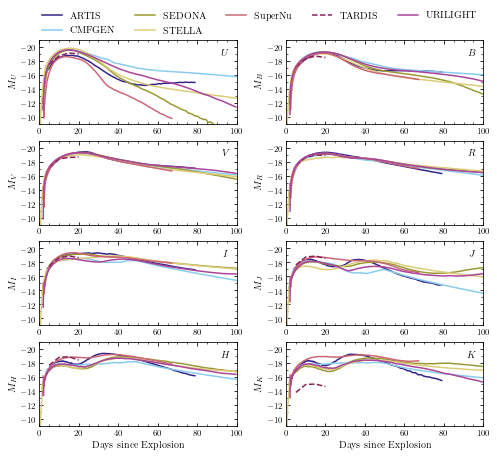

In [23]:
fig = plot_filter_light_curves(mag_data, model='toy06', t_range=[0,100], mag_range=[-9,-21])
fig.savefig("filter_light_curves_toy06.pdf")

Full light curves:

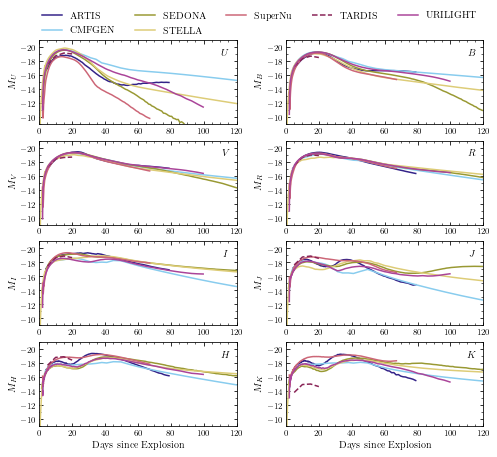

In [24]:
fig = plot_filter_light_curves(mag_data, model='toy06', t_range=[0, 120], mag_range=[-9, -21])
#fig.savefig("filter_light_curves_toy06_120d.pdf")

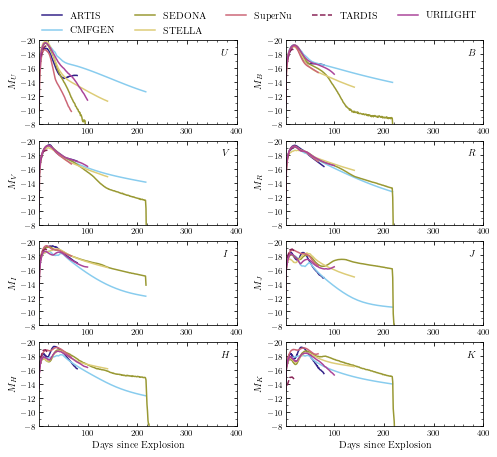

In [25]:
fig = plot_filter_light_curves(mag_data, t_range=[2.5, 400], mag_range=[-8, -20])

## Color curves

In [26]:
def plot_color_curves(mag_data, model='toy06', t_range=[2.5, 50],
                      mag_range=[-15, -20], color=['B', 'V'], nolegend=False):
    
    ## FIGSIZE
    fig = plt.figure(figsize=(3.32, 2.25))
    fig.subplots_adjust(left=.16, bottom=.19, right=.97, top=.97)
    ax = fig.add_subplot(111)
    
    for j, code in enumerate(SPECTRAL_CODES):
        if code == 'sumo' or code == 'artisnebular':
            # skip codes that are only late-time
            continue
        try:
            lc_data = mag_data[model][code]
            ax.plot(lc_data.time, lc_data[color[0]] - lc_data[color[1]],
                    label=CODE_LABELS[code], color=CODE_COLORS[code], ls=CODE_LINE_STYLE[code])
            ax.set_xlim(t_range[0], t_range[1])
            ax.set_ylabel('${} - {}$'.format(color[0], color[1]))
            ax.set_xlabel('Days since Explosion')
        except:
            pass
#     ax.legend(bbox_to_anchor=[0., 1.10], ncol=len(SPECTRAL_CODES), loc='center left', frameon=False)
    if not nolegend:
        ax.legend(loc='upper left', frameon=False, fontsize=8, ncol=2)
        
    ax.set_ylim(mag_range[0], mag_range[1])
    ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.5))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=0.1))

    return fig

Plot B-V and V-R around maximum:

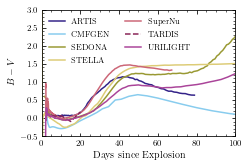

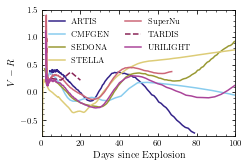

In [27]:
fig_BV = plot_color_curves(mag_data, model='toy06', t_range=[0, 100], mag_range=[-0.5, 3.0], color=['B', 'V'])
fig_VR = plot_color_curves(mag_data, model='toy06', t_range=[0, 100], mag_range=[-.8, 1.5], color=['V', 'R'])
fig_BV.savefig("color_BmV_toy06.pdf")
fig_VR.savefig("color_VmR_toy06.pdf")

Plot B-V and V-R for the full time series:

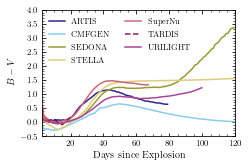

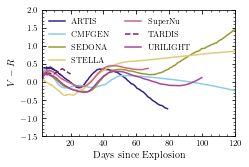

In [28]:
fig_BV = plot_color_curves(mag_data, mag_range=[-0.5, 4.0], t_range=[2.5, 120])
fig_VR = plot_color_curves(mag_data, mag_range=[-1.5, 2.0], color=['V', 'R'], t_range=[2.5, 120])
#fig_BV.savefig("BV_lightcurves_full.pdf")
#fig_VR.savefig("VR_lightcurves_full.pdf")

# Reader functions

In [29]:
def read_lbol(file):

    """read in lbol_edep_*.txt file
    """

    print('INFO - reading file '+file)

    with open(file, 'r') as f:

        ### read in header
        okhdr = 0
        while okhdr == 0:
            line = f.readline()
            if 'NTIMES' in line:
                nt = int(line.split()[1])
                okhdr = 1

    ### read numerical data
    t, lbol, edep = np.loadtxt(file, unpack=True)
    return t, lbol, edep
def get_max_bol(t,lbol):
    idx = np.where((lbol > 0) & (t > 0))[0]
    tt=t[idx];
    llbol=lbol[idx];
    imax=np.argmax(lbol)
    ifit=[imax-1,imax,imax+1]
    pfit=np.polyfit(tt[ifit],np.log10(llbol[ifit]),2)
    tmax=-pfit[1]/2/pfit[0]
    loglbolmax=pfit[2]-pfit[1]**2/4/pfit[0]
    #output
    return tmax, loglbolmax

###############################################################################

def read_phys(file):

    """read in phys_*.txt file
    """

    print('INFO - reading file '+file)

    with open(file, 'r') as f:

        ### read in header
        okhdr = 0
        while okhdr == 0:
            line = f.readline()
            if 'NTIMES' in line:
                nt = int(line.split()[1])
            elif 'TIMES' in line:
                split_line = line.split()
                tarrstr = split_line[1:]
                tarr = [float(tt) for tt in tarrstr]
                okhdr = 1
        nvels=[]
        velmids=[]
        temps=[]
        rhos=[]
        nes=[]
        natoms=[]
        for it in range(nt):
            oktmstp = 0
            while oktmstp == 0:
                line = f.readline()
                if 'TIME' in line:
                    oktmstp = 1
            line = f.readline()
            nvel = int(line.split()[1])
            nvels.append(nvel)
            line = f.readline()
            fff = np.loadtxt(f, unpack=True, max_rows=nvel)
            velmid = fff[0]
            temp = fff[1]
            rho = fff[2]
            ne = []
            natom = []
            if(len(fff) > 3):
                ne = fff[3]
            if(len(fff) > 4):
                natom = fff[4]
#           velmid, temp, rho, ne, natom = np.loadtxt(f, unpack=True, max_rows=nvel)
            velmids.append(velmid)
            temps.append(temp)
            rhos.append(rho)
            nes.append(ne)
            natoms.append(natom)
                

    #output
    return tarr, velmids, temps, rhos, nes, natoms

###############################################################################
def read_ions(file):

    """read in phys_*.txt file
    """

    print('INFO - reading file '+file)

    with open(file, 'r') as f:

        ### read in header
        okhdr = 0
        while okhdr == 0:
            line = f.readline()
            if 'NTIMES' in line:
                nt = int(line.split()[1])
            elif 'NSTAGES' in line:
                nstages = int(line.split()[1])
            elif 'TIMES' in line:
                split_line = line.split()
                tarrstr = split_line[1:]
                tarr = [float(tt) for tt in tarrstr]
                okhdr = 1
        nvels=[]
        velmids=[]
        nions=[]
        for it in range(nt):
            oktmstp = 0
            while oktmstp == 0:
                line = f.readline()
                if 'TIME' in line:
                    oktmstp = 1
            line = f.readline()
            nvel = int(line.split()[1])
            nvels.append(nvel)
            line = f.readline()
            fff = np.loadtxt(f, unpack=True, max_rows=nvel)
            velmid = fff[0]
            nion = fff[1:]
            velmids.append(velmid)
            nions.append(nion)
                

    #output
    return tarr, nstages, velmids, nions

###############################################################################

def insensitive_glob(pattern):
    def either(c):
        return '[%s%s]' % (c.lower(), c.upper()) if c.isalpha() else c
#   return glob.glob(''.join(map(either, pattern)))
    return glob.glob(''.join(either(char) for char in pattern))

###############################################################################

# Ejecta profiles

INFO - reading file /home/sblondin/git/repos/data1/toy06/phys_toy06_stella_fr600.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/phys_toy06_cmfgen.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/phys_toy06_stella.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/phys_toy06_artisnebular.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/phys_toy06_crab.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/phys_toy06_urilight.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/phys_toy06_sedona.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/phys_toy06_sumo.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/phys_toy06_tardis.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/phys_toy06_artis.txt


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


INFO - reading file /home/sblondin/git/repos/data1/toy06/phys_toy06_stella_fr600.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/phys_toy06_cmfgen.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/phys_toy06_stella.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/phys_toy06_artisnebular.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/phys_toy06_crab.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/phys_toy06_urilight.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/phys_toy06_sedona.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/phys_toy06_sumo.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/phys_toy06_tardis.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/phys_toy06_artis.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/phys_toy06_stella_fr600.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/phys_toy06_cmfgen.txt
INFO - reading file /home/sblondin/gi

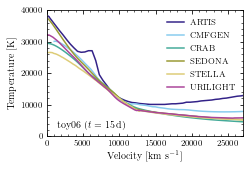

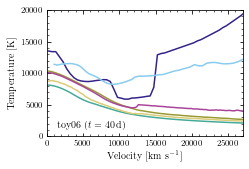

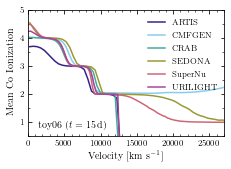

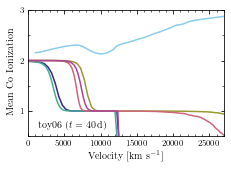

In [30]:
# read in files corresponding to quantity
data_dict = {}
quantities=['temp_15d','temp_40d','ionfrac_co_15d','ionfrac_co_40d'];

class args:
    quantity = 'none'
    model = 'toy06'
    
for aquantity in quantities:
    
    data_dict = {}
    args.quantity = aquantity
    filepath = os.path.join(path, args.model)
    files = glob.glob(filepath + '/phys_' + args.model + '*.txt')

    for physfile in files:
        
        # extract code name
        basename = os.path.basename(physfile)
        tmpstr = os.path.splitext(basename[5:])[0]
        codename = tmpstr[tmpstr.index('_')+1:]
                
        # read in file
        t, velmids, temps, rhos, nes, natoms = read_phys(physfile)
        
        # update dictionary
        if args.quantity == 'temp_15d' or args.quantity == 'temp_40d':
            if args.quantity == 'temp_15d':
                tplot = 15
            elif args.quantity == 'temp_40d':
                tplot = 40
            nt = min(range(len(t)), key=lambda i: abs(t[i]-tplot))
            if abs(t[nt]-tplot)<=2:
                data_dict[codename] = {'vel':velmids[nt], 'temp':temps[nt]}

    if args.quantity == 'ionfrac_co_40d' or args.quantity == 'ionfrac_co_15d':
        files = glob.glob(filepath + '/ionfrac_co_' + args.model + '*.txt')

        for ionfile in files:
            
            # extract code name
            basename = os.path.basename(ionfile)
            tmpstr = os.path.splitext(basename[11:])[0]
            codename = tmpstr[tmpstr.index('_')+1:]

            # read in file
            tion, nstages, velmidsions, nions = read_ions(ionfile)
            
            # update dictionary
            if args.quantity == 'ionfrac_co_15d' or args.quantity == 'ionfrac_co_40d':
                if args.quantity == 'ionfrac_co_15d':
                    tplot = 15
                elif args.quantity == 'ionfrac_co_40d':
                    tplot = 40
                nt = min(range(len(tion)), key=lambda i: abs(tion[i]-tplot))
                nions_t = nions[nt]
                if codename =='supernu':
                    nions_t = nions_t[2:]
                meanion = np.array(nions_t[0])*0
                for stage in range(nstages):
                    meanion = meanion + stage * np.array(nions_t[stage])
                if abs(tion[nt]-tplot)<=2:
                    data_dict[codename] = {'vel':velmidsions[nt], 'meanion':np.ndarray.tolist(meanion)}
    
    ## FIGSIZE
    fig = plt.figure(figsize=(3.32, 2.25))
    fig.subplots_adjust(left=.17, bottom=.19, right=.99, top=.97)
    ax = fig.add_subplot(111)
    
    axins = None
    if args.quantity == 'temp_15d':
        xx = 'vel'
        yy = 'temp'
        xtit = r'Velocity [km s$^{-1}$]'
        ytit = r'Temperature [K]'
        plt.xlim(0, 27000)
        plt.ylim(0, 40000)
        leglocation='upper right'
        textlabel = 'toy06 ($t=15$\,d)'
    elif args.quantity == 'temp_40d':
        xx = 'vel'
        yy = 'temp'
        xtit = r'Velocity [km s$^{-1}$]'
        ytit = r'Temperature [K]'
        plt.xlim(0, 27000)
        plt.ylim(0, 20000)
        leglocation=None
        textlabel = 'toy06 ($t=40$\,d)'
    elif args.quantity == 'ionfrac_co_15d':
        xx = 'vel'
        yy = 'meanion'
        xtit = r'Velocity [km s$^{-1}$]'
        ytit = r'Mean Co Ionization'
        plt.xlim(0, 27000)
        plt.ylim(.5, 5)
        leglocation='upper right'
        textlabel = 'toy06 ($t=15$\,d)'
    elif args.quantity == 'ionfrac_co_40d':
        xx = 'vel'
        yy = 'meanion'
        xtit = r'Velocity [km s$^{-1}$]'
        ytit = r'Mean Co Ionization'
        plt.xlim(0, 27000)
        plt.ylim(0.5, 3.0)
        leglocation=None
        textlabel = 'toy06 ($t=40$\,d)'
        
    ax.set_xlabel(xtit)
    ax.set_ylabel(ytit)
    if yy == 'meanion':
        ax.yaxis.set_major_locator(ticker.MultipleLocator(base=1))
        ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=0.5))
    
    for code in CODE_NAMES: #data_dict.keys():
        # skip codes
        if code in ['artisnebular','kepler','sumo','tardis']: continue
        if code == 'stella':
            codestr = 'stella_fr600'
        elif model == 'kepler':
            codestr = 'kepler0p1'
        else:
            codestr = code
        if codestr in sorted(data_dict.keys()):
            pax = ax.plot(data_dict[codestr][xx], data_dict[codestr][yy], label=CODE_LABELS[code], color=CODE_COLORS[code], 
                        ls=CODE_LINE_STYLE[code])
        
    if leglocation is not None:
        ax.legend(fontsize='small', loc=leglocation, frameon=False)
        
    ax.text(.05, .12, textlabel, va='top', ha='left', transform=ax.transAxes)   
        
    plt.savefig(args.quantity + '_' + args.model + '.pdf')

INFO - reading file /home/sblondin/git/repos/data1/toy06/lbol_edep_toy06_crab.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/lbol_edep_toy06_kepler0p03.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/lbol_edep_toy06_sedona.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/lbol_edep_toy06_cmfgen.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/lbol_edep_toy06_stella.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/lbol_edep_toy06_kepler0p1.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/lbol_edep_toy06_stella_fr600.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/lbol_edep_toy06_urilight.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/lbol_edep_toy06_supernu.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/lbol_edep_toy06_artis.txt


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


INFO - reading file /home/sblondin/git/repos/data1/toy06/lbol_edep_toy06_artis.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/lbol_edep_toy06_cmfgen.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/lbol_edep_toy06_crab.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/lbol_edep_toy06_kepler0p1.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/lbol_edep_toy06_sedona.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/lbol_edep_toy06_stella_fr600.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/lbol_edep_toy06_supernu.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/lbol_edep_toy06_urilight.txt
INFO - reading file /home/sblondin/git/repos/data1/toy01/lbol_edep_toy01_artis.txt
INFO - reading file /home/sblondin/git/repos/data1/toy01/lbol_edep_toy01_cmfgen.txt
INFO - reading file /home/sblondin/git/repos/data1/toy01/lbol_edep_toy01_crab.txt
INFO - reading file /home/sblondin/git/repos/data1/toy01/lbol_edep_toy

/home/sblondin/anaconda3/envs/starkit/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


INFO - reading file /home/sblondin/git/repos/data1/toy06/lbol_edep_toy06_crab.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/lbol_edep_toy06_kepler0p03.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/lbol_edep_toy06_sedona.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/lbol_edep_toy06_cmfgen.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/lbol_edep_toy06_stella.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/lbol_edep_toy06_kepler0p1.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/lbol_edep_toy06_stella_fr600.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/lbol_edep_toy06_urilight.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/lbol_edep_toy06_supernu.txt
INFO - reading file /home/sblondin/git/repos/data1/toy06/lbol_edep_toy06_artis.txt


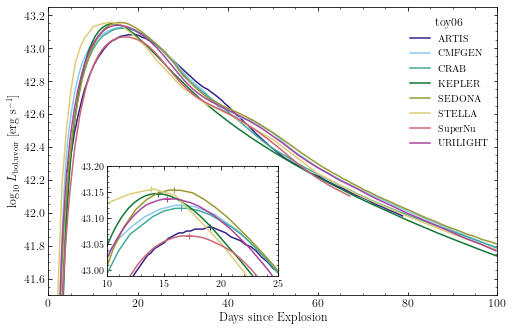

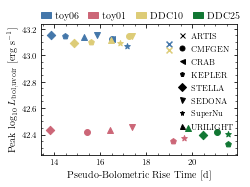

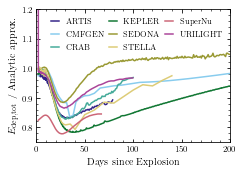

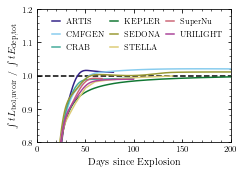

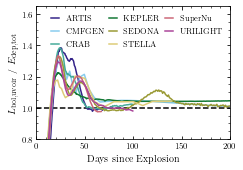

In [31]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy import integrate

data_dict = {}
quantities=['lbol','edeptot','econs','lboloveredeptot'];

class args:
    quantity = 'none'
    model = 'toy06'
    
for aquantity in quantities:
    args.quantity = aquantity
    filepath = os.path.join(path, args.model)
    files = glob.glob(filepath + '/lbol_edep_' + args.model + '*.txt')

    for lbolfile in files:
        
        # extract code name
        basename = os.path.basename(lbolfile)
        tmpstr = os.path.splitext(basename[10:])[0]
        codename = tmpstr[tmpstr.index('_')+1:]
        if codename in ['artisnebular','sumo']:
            continue

        # read in file
        t, lbol, edeptot = read_lbol(lbolfile)
        tmax, loglbolmax = get_max_bol(t,lbol)
        
        # update dictionary
        if args.quantity == 'lbol':
            idx = np.where((lbol > 0) & (t > 0))[0]
            data_dict[codename] = {'time':t[idx], 'lbol':np.log10(lbol[idx]),'tmax':tmax,'loglbolmax':loglbolmax}
        elif args.quantity == 'edeptot':
            idx = np.where((edeptot > 0) & (t > 0))[0]
            tt=t[idx];
            Qdec=0.6*(6.45*np.exp(-tt/8.8)+1.45*np.exp(-tt/111.3))*1e43
            fdep=0.97*(1-np.exp(-40**2/tt**2))+0.03
            Qdep=fdep*Qdec
            data_dict[codename] = {'time':t[idx], 'edeptot':edeptot[idx]/Qdep}
        elif args.quantity == 'econs':
            idx = np.where((lbol > 0) & (t > 0) & (edeptot > 0) & (t > 0))[0]
            intlbol=integrate.cumtrapz(lbol[idx]*t[idx],t[idx],initial=0)
            intedeptot=integrate.cumtrapz(edeptot[idx]*t[idx],t[idx],initial=0)
            data_dict[codename] = {'time':t[idx], 'econs':intlbol/intedeptot}
        elif args.quantity == 'lboloveredeptot':
            idx = np.where((lbol > 0) & (t > 0) & (edeptot > 0) & (t > 0))[0]
            data_dict[codename] = {'time':t[idx], 'lboloveredeptot':lbol[idx]/edeptot[idx]}
        elif args.quantity == 'lboloverint':
            idx = np.where((lbol > 0) & (t > 0) & (edeptot > 0) & (t > 0))[0]
            intlbol=integrate.cumtrapz(lbol[idx]*t[idx],t[idx],initial=0)
            intedeptot=integrate.cumtrapz(edeptot[idx]*t[idx],t[idx],initial=0)
            data_dict[codename] = {'time':t[idx], 'lboloverint':t[idx]**2.5*lbol[idx]/intlbol}

    # plot
    plt.ion()
    
    ## FIGSIZE
    if args.quantity == 'lbol':
        figsize = (6.97, 4.5)
    else:
        figsize = (3.32, 2.25)
    fig = plt.figure(figsize=figsize)
    if args.quantity == 'lbol':
        fig.subplots_adjust(left=.08, bottom=.1, right=.975, top=.99)
    else:
        fig.subplots_adjust(left=.16, bottom=.16, right=.97, top=.98)
    ax = fig.add_subplot(111)
    
    axins = None
    if args.quantity == 'lbol':
        xx = 'time'
        yy = 'lbol'
        xtit = r'Days since Explosion'
        ytit = r'$\log_{10} L_{\mathrm{bol,uvoir}}$ [erg s$^{-1}$]'
        plt.xlim(0, 100)
        plt.ylim(41.5, 43.25)

        # axins = ax.inset_axes([0, 50, 41, 43],  transform=ax.transData)
        axins = inset_axes(ax, loc='lower left', width='100%', height='100%',
                            bbox_to_anchor=(.12, .05, 0.38, 0.38),
                            bbox_transform=ax.transAxes,)  # borderpad=2 loc='lower center',
        #axins.xaxis.set_minor_locator(ticker.AutoMinorLocator())
        axins.set_xlim(10, 25)
        #axins.yaxis.set_minor_locator(ticker.AutoMinorLocator())
        axins.set_ylim(42.99, 43.2)
        axins.xaxis.set_major_locator(ticker.MultipleLocator(base=5))
        axins.xaxis.set_minor_locator(ticker.MultipleLocator(base=1))
        axins.tick_params(axis='both', which='major', labelsize=10)
    elif args.quantity == 'edeptot':
        xx = 'time'
        yy = 'edeptot'
        xtit = r'Days since Explosion'
        ytit = r'$E_{\mathrm{dep,tot}}$ / Analytic approx.'
        plt.xlim(0,200)
        plt.ylim(0.75,1.2)
    elif args.quantity == 'econs':
        xx = 'time'
        yy = 'econs'
        xtit = r'Days since Explosion'
        ytit = r'$\int t L_{\mathrm{bol,uvoir}}$ / $\int t E_{\mathrm{dep,tot}}$'
        plt.xlim(0,200)
        plt.ylim(0.8,1.2)
        plt.plot([0,200],[1,1],'k--')
    elif args.quantity == 'lboloveredeptot':
        xx = 'time'
        yy = 'lboloveredeptot'
        xtit = r'Days since Explosion'
        ytit = r'$L_{\mathrm{bol,uvoir}}$ / $E_{\mathrm{dep,tot}}$'
        plt.xlim(0,200)
        plt.ylim(0.8,1.65)
        plt.plot([0,200],[1,1],'k--')

    ax.set_xlabel(xtit)
    ax.set_ylabel(ytit)
    if args.quantity == 'lbol':
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.xaxis.label.set_size(12)
        ax.yaxis.label.set_size(12)

    for code in sorted(data_dict.keys()):
                
        # skip artisnebular since starts at ~200d
        # skip STELLA run with default 130 frequency bins for toy06
        # skip TARDIS since Lbol is input
        if code in ['artisnebular','kepler0p03','stella','tardis']: continue
        if code in ['sumo'] and args.quantity == 'lbol': continue
            
        pax = ax.plot(data_dict[code][xx], data_dict[code][yy], label=CODE_LABELS[code], color=CODE_COLORS[code], ls=CODE_LINE_STYLE[code])
        col = pax[0].get_color()
        if args.quantity == 'lbol':
            data_dict[code]['col'] = col
            axins.plot(data_dict[code][xx], data_dict[code][yy], color=col, ls=CODE_LINE_STYLE[code])
            axins.plot(data_dict[code]['tmax'], data_dict[code]['loglbolmax'], color=col, marker='+')
            
    leglocation = 'upper right'
#     if args.quantity == 'edeptot':
#         leglocation = 'lower right'
    if args.quantity == 'lbol':
        leg = ax.legend(fontsize='medium', title=args.model, loc=leglocation, frameon=False)
        leg.get_title().set_fontsize('large')
    else:
        ax.legend(fontsize=8, loc=leglocation, frameon=False, ncol=3, columnspacing=0.7, handlelength=1.0)
    
    plt.savefig(args.quantity + '_' + args.model + '.pdf')
    
    ## trise vs tpeak
    if args.quantity == 'lbol':
        
        fig = plt.figure(figsize=(3.32, 2.5))
        ax = fig.add_subplot(111)
        fig.subplots_adjust(left=.17, bottom=.17, right=.99, top=.9)

        ax.set_xlabel('Pseudo-Bolometric Rise Time [d]')
        ax.set_ylabel('Peak $\log_{10}L_{\mathrm{bol,uvoir}}$ [erg s$^{-1}$]')
        ax.set_xmargin(0.05)
        ax.set_ymargin(0.1)

        for model in MODEL_NAMES:
            for code in sorted(data_dict.keys()):
                
                # skip artisnebular since starts at ~200d
                # skip STELLA run with default 130 frequency bins for toy06
                # skip TARDIS since Lbol is input
                if code in ['artisnebular','kepler0p03','tardis']: continue
                if model == 'toy06' and code == 'stella': continue
                if code in ['sumo'] and args.quantity == 'lbol': continue
                    
                # need to refit tmax since only done for toy06 above
                filepath = os.path.join(path, model)
                lbolfile = filepath + '/lbol_edep_' + model + '_' + code + '.txt'
                
                # read in file
                try:
                    t, lbol, edeptot = read_lbol(lbolfile)
                    tmax, loglbolmax = get_max_bol(t,lbol)
                    
                    ax.scatter(tmax, loglbolmax, label=CODE_LABELS[code], 
                               color=MODEL_COLORS[model], marker=CODE_SYMBOLS[code], s=35)
                except:
                    pass
        
        legend_handles = []
        for model in MODEL_NAMES:
            legend_handles.append(mpatches.Patch(color=MODEL_COLORS[model], label=MODEL_LABELS[model]))
        model_legend = ax.legend(handles=legend_handles, bbox_to_anchor=[-.05,0,1,1.17], ncol=4,
                                  loc='upper left', frameon=False, handlelength=.6, columnspacing=1.)

        for patch in model_legend.get_patches():
            patch.set_height(6)
            patch.set_width(10)

        code_legend_handles = []
        for code, symbol in CODE_SYMBOLS.items():
            # skip codes that are only late-time or do not produce light curves
            if code in ['artisnebular','sumo','tardis']:
                continue
            # code_legend_handles.append
            marker = mlines.Line2D([], [], color='black', marker=symbol, label=CODE_LABELS[code], lw=0., markersize=5)

            # avoid duplicate entries (e.g. for STELLA)    
            if marker.get_label() not in [m.get_label() for m in code_legend_handles]:
                code_legend_handles.append(marker)

        code_legend = ax.legend(handles=code_legend_handles, bbox_to_anchor=[0,0,1.02,1],
                                 loc='upper right', frameon=False, fontsize=8, handlelength=.6, )

        plt.gca().add_artist(model_legend)
        plt.savefig('lbolpeak_vs_trisebol.pdf')        
        
#         # print(data_dict.keys())
        
#         ## FIGSIZE
#         fig = plt.figure()
#         ax = fig.add_subplot(111)
        
#         models=['toy06','toy01']
#         markers=['+','*']
#         for (imodel,model) in enumerate(models):
#             filepath = os.path.join(path, 'data1', model)
#             files = glob.glob(filepath + '/lbol_edep_' + model + '*.txt')
#             for lbolfile in files:
#                 # extract code name
#                 codenametmp = lbolfile[lbolfile.rfind('_')+1:] # <code>.txt
#                 codename = codenametmp[:-4]
#                 if ((codename in data_dict.keys())&(codename!='sumo')):
#                 # read in file
#                     t, lbol, edeptot=read_lbol(lbolfile)
#                     tmax, loglbolmax = get_max_bol(t,lbol)
#                     ax.plot(tmax, loglbolmax, data_dict[codename]['col'], marker=markers[imodel], label=codename+' '+model, ls='none', ms=10)
                
#         plt.xlim(12,25)
#         plt.ylim(42,43.5)
#         plt.xlabel('Peak Time, Days since Explosion')
#         plt.ylabel('Peak $\log_{10}L_{\mathrm{bol,uvoir}}$ [erg s$^{-1}$]')
#         ax.legend(fontsize='small', loc='upper right')

#         plt.savefig('lbolpeak_vs_trisebol.pdf')

In [32]:
def read_magnitudes(fname):
    COL_NAMES = ['time', 'U', 'B', 'V', 'R', 'I', 'J', 'H', 'K']
    mag_table = pd.read_csv(fname, delim_whitespace=True, comment='#', names=COL_NAMES)
    mag_table.iloc[:, 1:] = mag_table.iloc[:,1:].replace(99.999, np.nan)
    return mag_table
    
def read_spectrum(fname):
    col_names = ['wavelength']
    with open(fname, encoding='utf8') as fh:
        for i, line in enumerate(fh):
            if i==2:
                times = list(map(np.float64, line.strip().split(':')[1].split()))
    
    spectrum = pd.read_csv(fname, delim_whitespace=True, comment='#', header=None)
    spectrum.columns = col_names + times
    return spectrum

def read_tgas(fname):
    col_names = ['velocity']
    with open(fname, encoding='utf8') as fh:
        for i, line in enumerate(fh):
            if i==2:
                times = list(map(np.float64, line.strip().split(':')[1].split()))
    
    spectrum = pd.read_csv(fname, delim_whitespace=True, comment='#', header=None, names=col_names + times)
    return spectrum

In [33]:
model = 'toy06'

## Reading the data
spectral_data = {}
for code_name in CODE_NAMES:
    
    if model == 'toy06' and code_name == 'stella':
        codestr = 'stella_fr600'
    elif model == 'kepler':
        codestr = 'kepler0p1'
    else:
        codestr = code_name
    fname = '{2}/{1}/spectra_{1}_{0}.txt'.format(codestr, model, path)
    
    if not os.path.exists(fname):
        continue
    try:
        spectral_data[codestr] = read_spectrum(fname)
    except UnicodeDecodeError:
        print('File {0} does raise a UnicodeDecodeError'.format(fname))
        pass
    except IndexError:
        print('File {0} does raise a IndexError'.format(fname))
        pass
    except ValueError:
        print('File {0} does raise a ValueError'.format(fname))
        pass

# ## Spectral Comparison Plots ##

In [34]:
def get_lbol_peak_time(model, code):
    
    if code == 'tardis':
        peak_time = 15.0
    else:
        fname = '{2}/{1}/lbol_edep_{1}_{0}.txt'.format(code, model, path)
        lbol = pd.read_csv(fname, delim_whitespace=True, comment='#', names=['time', 'lbol', 'edep'])
        peak_ind = np.argmax(np.log10(lbol.lbol.values))
        peak_time = lbol.time.values[peak_ind]
        
    return peak_time

toy06 artis 18.82
toy06 cmfgen 16.1
toy06 sedona 15.5
toy06 stella_fr600 14.0831
toy06 supernu 17.149
toy06 tardis 15.0
toy06 urilight 15.04793


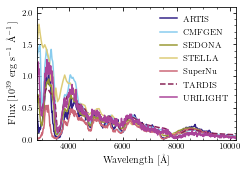

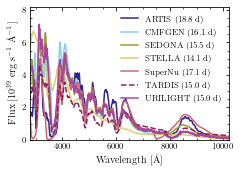

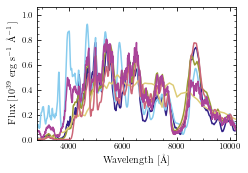

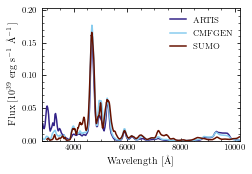

In [35]:
###################### OPTICAL PLOTS ############################

SPECTRAL_TIMES = [5, 'lbolpeak', 50, 200]

FLUX_DIV = 1e39
flux_div_str = '$10^{{{:d}}}$'.format(int(np.log10(FLUX_DIV)))

wvl_range = (2800, 10200)
figs = []

interpolators = {}
for code_name in sorted(spectral_data.keys()): #CODE_NAMES:
    time = spectral_data[code_name].columns.values
    try:
        time = time[1:].astype(np.float64)
        spectra = spectral_data[code_name].iloc[:, 1:].values.astype(np.float64)
    except ValueError:
        print("Spectral data from code_name {0} has problems".format(code_name))
        continue
    interpolators[code_name] = interpolate.interp1d(time, spectra, fill_value=np.nan, bounds_error=False)


for time in SPECTRAL_TIMES:
    
    ## FIGSIZE
    fig = plt.figure(figsize=(3.32, 2.25))
    fig.subplots_adjust(left=.14, bottom=.17, right=.97, top=.99)
    ax = fig.add_subplot(111)
    
    ax.set_xlim(wvl_range)
    ax.set_xlabel('Wavelength [\AA]')
    ax.set_ylabel('Flux ['+flux_div_str+' erg s$^{-1}$ \AA$^{-1}$]')
    
    ylim_peak = 0
    for code_name, interpolator in interpolators.items():

        # don't plot nebular spectra for early times
        if time in [5,'lbolpeak',50] and code_name in ['artisnebular','sumo']:
            continue
        # don't plot SEDONA nebular spectrum since LTE assumed
        elif time in [200] and code_name not in ['artisnebular','cmfgen','sumo']:
            continue

        if time == 'lbolpeak':
            peak_time = get_lbol_peak_time(model, code_name)
            print(model, code_name, peak_time)
            
        wavelength = spectral_data[code_name].wavelength
        idxw = np.where((wavelength >= wvl_range[0]) & (wavelength <= wvl_range[1]))[0]
        if time == 'lbolpeak':
            plt.plot(wavelength, interpolator(peak_time)/FLUX_DIV, 
                     label='{:s} ({:.1f}\,d)'.format(CODE_LABELS[code_name], peak_time), 
                     color=CODE_COLORS[code_name], ls=CODE_LINE_STYLE[code_name])
            if max(interpolator(peak_time)[idxw])/FLUX_DIV > ylim_peak:
                ylim_peak = max(interpolator(peak_time)[idxw])/FLUX_DIV
        else:
            plt.plot(wavelength, interpolator(time)/FLUX_DIV, label=CODE_LABELS[code_name], 
                     color=CODE_COLORS[code_name],ls=CODE_LINE_STYLE[code_name])
            if max(interpolator(time)[idxw])/FLUX_DIV > ylim_peak:
                ylim_peak = max(interpolator(time)[idxw])/FLUX_DIV
            
    ax.set_ylim(0., ylim_peak*1.15)
    if time not in [50]:
        ax.legend(fontsize='small', frameon=False) #, title='{1} {0} days'.format(time, model))
        
    if time == 'lbolpeak':
        plt.savefig('spectra_optical_{0}_{1}.pdf'.format(model, time))
    else:
        plt.savefig('spectra_optical_{0}_{1}d.pdf'.format(model, time))        
#     figs.append(fig)

In [36]:
# The above figures are stored in the figs list for further modifications.
# for i,f in enumerate(figs):
#     f.savefig('spec_comp_fig_optical'+str(i)+'.pdf', bbox_inches='tight')

INFO - reading file /home/sblondin/git/repos/data1/input_models/snia_toy01.dat
INFO - reading file /home/sblondin/git/repos/data1/input_models/snia_toy06.dat
INFO - reading file /home/sblondin/git/repos/data1/input_models/DDC10_0.976d
INFO - reading file /home/sblondin/git/repos/data1/input_models/DDC25_1.300d
INFO - created output file density_profile.pdf


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


INFO - created output file composition_profile_toy01.pdf
INFO - created output file composition_profile_toy06.pdf
INFO - created output file composition_profile_ddc10.pdf
INFO - created output file composition_profile_ddc25.pdf


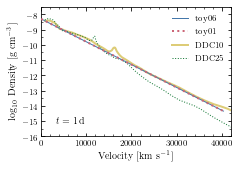

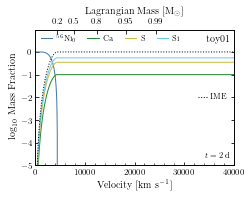

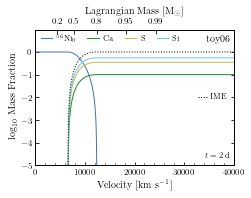

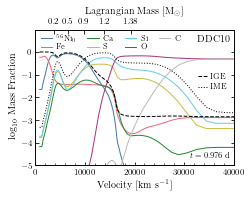

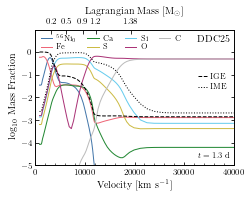

In [37]:
### constants
MSUN = 1.989e+33  # solar mass (g)

def read_snia_toy_model(file):

    '''read in snia_toyXX.dat file
    '''

    print('INFO - reading file ' + file)

    with open(file, 'r') as f:
        
        ### read in header
        okhdr = 0
        while okhdr == 0:
            line = f.readline()
            if 'nzones' in line:
                nzones = int(line.split()[3])
            elif 'time at which' in line:
                time = float(line.split()[-2])
            elif 'IMEs' in line:
                idx0 = line.index('IMEs =') + 7
                idx1 = line.index(' with relative fractions')
                imes = line[idx0:idx1].lower().split(', ') # 'Ca, S, Si' -> ['ca', 's', 'si']
            elif '#(1)' in line:
                okhdr = 1

        ### output arrays
        out = {}
        out['nzones'] = nzones
        out['time'] = time
        out['imes'] = imes
        out['vel'] = np.zeros(nzones)
        out['dmass'] = np.zeros(nzones)
        out['mass'] = np.zeros(nzones)
        out['ige_0'] = np.zeros(nzones)
        out['ni56_0'] = np.zeros(nzones)
        out['ime'] = np.zeros(nzones)
        out['ti'] = np.zeros(nzones)
        out['c+o'] = np.zeros(nzones)
        out['rad'] = np.zeros(nzones)
        out['dens'] = np.zeros(nzones)
        out['temp'] = np.zeros(nzones)
        out['ni56'] = np.zeros(nzones)
        out['ni'] = np.zeros(nzones)
        out['co'] = np.zeros(nzones)
        out['fe'] = np.zeros(nzones)
        for ime in imes:
            out[ime] = np.zeros(nzones)
        out['o'] = np.zeros(nzones)
        out['c'] = np.zeros(nzones)

        ### read numerical data
        for i in range(nzones):
            line = f.readline()
            split_line = line.split()
            out['vel'][i] = float(split_line[1])
            out['dmass'][i] = float(split_line[2])
            out['mass'][i] = float(split_line[3])
            out['ige_0'][i] = float(split_line[4])
            out['ni56_0'][i] = float(split_line[5])
            out['ime'][i] = float(split_line[6])
            out['ti'][i] = float(split_line[7])
            out['c+o'][i] = float(split_line[8])
            out['rad'][i] = float(split_line[9])
            out['dens'][i] = float(split_line[10])
            out['temp'][i] = float(split_line[11])
            out['ni56'][i] = float(split_line[12])
            out['ni'][i] = float(split_line[13])
            out['co'][i] = float(split_line[14])
            out['fe'][i] = float(split_line[15])
            for iime, ime in enumerate(imes):
                out[ime][i] = float(split_line[16 + iime])
            out['o'][i] = float(split_line[-2])
            out['c'][i] = float(split_line[-1])
                                    
    out['units'] = 'time: days\nvel: km/s\ndmass: msun\nmass: msun\nrad: cm\ndens: g/cm^3\ntemp: K'
    
    return out
    
###############################################################################

def read_ddc_model(file):

    '''read in DDC_*d file

    UPDATE 2022-03-17: mass fractions at t=t0 are no longer present in input files
                       (but we compute 56Ni mass fraction at t=0)
    '''

    THALF_56NI = 6.0749  # 56Ni->56Co decay half-life (days) used in DDC model runs
    decay_const_ni56 = np.log(2) / THALF_56NI
    
    print('INFO - reading file ' + file)

    with open(file, 'r') as f:
        
        ### read in header
        okhdr = 0
        while okhdr == 0:
            line = f.readline()
            if 'TIME' in line:
                time = float(line.split()[-2])
            # elif 's PAST EXPLOSION' in line:
            #     t0 = float(line.split()[4])
            elif 'elemental' in line:
                idx_elem = line.split()[1][1:-1]
                idxelem0 = int(idx_elem[:idx_elem.index(')')]) - 1
                idxelem1 = int(idx_elem[idx_elem.index('(')+1:])
            elif 'isotopic' in line and 'days since explosion' in line:
                idx_iso = line.split()[1][1:-1]
                idxiso0 = int(idx_iso[:idx_iso.index(')')]) - 1
                idxiso1 = int(idx_iso[idx_iso.index('(')+1:])
            # elif 'isotopic' in line and 'seconds since explosion' in line:
            #     idx_iso = line.split()[1][1:-1]
            #     idxiso00 = int(idx_iso[:idx_iso.index(')')]) - 1
            #     idxiso01 = int(idx_iso[idx_iso.index('(')+1:])
            elif '#vel[km/s]' in line:
                elems = line.split()[idxelem0:idxelem1]
                isos = line.split()[idxiso0:idxiso1]
                # iso0s = line.split()[idxiso00:idxiso01]
                line = f.readline()
                okhdr = 1

        ### output arrays
        vel = []
        rad = []
        dvol = []
        dens = []
        dmass = []
        temp = []
        xelem = {}
        xiso = {}
        # xiso0 = {}
        for elem in elems:
            xelem[elem] = []
        for iso in isos:
            xiso[iso] = []
        # for iso in iso0s:
        #     xiso0[iso] = []
        
        ### read numerical data
        while 1:
            line = f.readline()
            # to handle EOF
            if not line:
                break
            else:
                split_line = line.split()
                vel.append(float(split_line[0]))
                rad.append(float(split_line[1]))
                dvol.append(float(split_line[2]))
                dens.append(float(split_line[3]))
                dmass.append(float(split_line[4]))
                temp.append(float(split_line[5]))
                for ielem, elem in enumerate(elems):
                    xelem[elem].append(float(split_line[idxelem0 + ielem]))
                for iiso, iso in enumerate(isos):
                    xiso[iso].append(float(split_line[idxiso0 + iiso]))
                # for iiso, iso in enumerate(iso0s):
                #     xiso0[iso].append(float(split_line[idxiso00 + iiso]))

    # output
    out = {}
    out['time'] = time
    # out['t0'] = t0
    out['elem'] = elems
    out['iso'] = isos
    # out['iso_0'] = iso0s
    out['vel'] = np.array(vel)
    out['rad'] = np.array(rad)
    out['dvol'] = np.array(dvol)
    out['dens'] = np.array(dens)
    out['dmass'] = np.array(dmass)
    out['temp'] = np.array(temp)
    for elem in elems:
        out[elem] = np.array(xelem[elem])
    for iso in isos:
        out[iso] = np.array(xiso[iso])
        if iso == 'ni56':
            # 56Ni at t=0 inferred from 56Ni(t)
            # note that decay_const_ni56 is in /days and time is in days
            out['ni56_0'] = out['ni56'] * np.exp(decay_const_ni56 * time)
    # for iso in iso0s:
    #     out[iso] = np.array(xiso0[iso])
    
    # out['units'] = 'time: days\nt0: seconds\nvel: km/s\nrad: cm\ndvol: cm^3\ndens: g/cm^3\ndmass: g\ntemp: K'
    out['units'] = 'time: days\nvel: km/s\nrad: cm\ndvol: cm^3\ndens: g/cm^3\ndmass: g\ntemp: K'

    return out

if __name__ == '__main__':

    import matplotlib.ticker as ticker
    
    path2data = path + 'input_models'

    toy01 = read_snia_toy_model(path2data +'/' + 'snia_toy01.dat')
    toy06 = read_snia_toy_model(path2data +'/' + 'snia_toy06.dat')
    ddc10 = read_ddc_model(path2data +'/' + 'DDC10_0.976d')
    ddc25 = read_ddc_model(path2data +'/' + 'DDC25_1.300d')
    model_dicts = {'toy01':toy01, 'toy06':toy06, 'DDC10':ddc10, 'DDC25':ddc25}

        
    ###########################
    # Figure: density profiles
    ###########################

    # compute density at reference time
    tref = 1.0 # days since explosion
    toy01_densscl = (toy01['time'] / tref)**3 
    toy06_densscl = (toy06['time'] / tref)**3 
    ddc10_densscl = (ddc10['time'] / tref)**3 
    ddc25_densscl = (ddc25['time'] / tref)**3 

    # start figure
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif', serif='Times New Roman', size=10) # define absolute font size here...
    plt.rc('xtick', labelsize='small') # ... relative font sizes thereafter
    plt.rc('ytick', labelsize='small')
    plt.rc('legend', fontsize='medium')

    fig = plt.figure(figsize=(3.32, 2.25))
    fig.subplots_adjust(left=.18, bottom=.19, right=.975, top=.99)
    ax = fig.add_subplot(111)

    # axis parameters
    ax.set_xlim(0, 4.2e4)
    ax.set_ylim(-16, -7.5)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(base=1))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=0.5))
    ax.set_xlabel(r'Velocity [km s$^{-1}$]')
    ax.set_ylabel(r'$\log_{10}$ Density [g cm$^{-3}$]')

    # plot
#     colorcycle = ['#4477AA', '#CC6677', '#DDCC77', '#117733']
    ax.plot(toy06['vel'], np.log10(toy06['dens'] * toy06_densscl), color=MODEL_COLORS['toy06'], ls='-' , lw=1.0, label='toy06', zorder=10)
    ax.plot(toy01['vel'], np.log10(toy01['dens'] * toy01_densscl), color=MODEL_COLORS['toy01'], ls=':' , lw=2.0, label='toy01', zorder=10)
    ax.plot(ddc10['vel'], np.log10(ddc10['dens'] * ddc10_densscl), color=MODEL_COLORS['ddc10'], ls='-' , lw=2.0, label='DDC10', zorder=1)
    ax.plot(ddc25['vel'], np.log10(ddc25['dens'] * ddc25_densscl), color=MODEL_COLORS['ddc25'], ls=':', lw=1.0, label='DDC25', zorder=1)

    # legend and labels
    ax.legend(frameon=False, fontsize='small')
    ax.text(.08, .1, '$t = {:d}$\,d'.format(int(tref)), transform=ax.transAxes)
    
    plt.savefig('density_profile.pdf')
    print('INFO - created output file density_profile.pdf')


    #########################################
    # global params for composition profiles
    #########################################

    # x- and y-lim
    xlim = (0., 4e4)
    ylim = (-5, .99)
    
    # color scheme
    # see https://personal.sron.nl/~pault/#sec:qualitative
    col_ni56 = '#4477AA'
    col_fe   = '#EE6677'
    col_ca   = '#228833'
    col_s    = '#CCBB44'
    col_si   = '#66CCEE'
    col_o    = '#AA3377'
    col_c    = '#BBBBBB'
    col_ime  = 'k' ; ls_ime = ':'
    col_ige  = 'k' ; ls_ige = '--'

    # legend parameters
    legend_dict = dict(
        loc = 'upper left',
        frameon = False,
        borderpad = 0.2,
        ncol = 4,
        columnspacing = 1.5,
        labelspacing = 0.2,
        fontsize = 7.5,
        handlelength = 1.5,
        handletextpad=0.6
    )
    
    
    #####################################
    # Figure: toy01 composition profiles
    #####################################

    # start figure
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif', serif='Times New Roman', size=10) # define absolute font size here...
    plt.rc('xtick', labelsize='small') # ... relative font sizes thereafter
    plt.rc('ytick', labelsize='small')
    plt.rc('legend', fontsize='medium')

    fig = plt.figure(figsize=(3.32, 2.62))
    fig.subplots_adjust(left=.12, bottom=.15, right=.95, top=.87)
    ax = fig.add_subplot(111)

    # axis parameters
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(base=1))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=0.5))
    ax.set_xlabel(r'Velocity [km s$^{-1}$]')
    ax.set_ylabel(r'$\log_{10}$ Mass Fraction')

    # plot   
    idx = np.where(toy01['ni56_0'] == 0.)
    toy01['ni56_0'][idx] = 1e-99
    idx = np.where(toy01['ca'] == 0.)
    toy01['ca'][idx] = 1e-99
    idx = np.where(toy01['s'] == 0.)
    toy01['s'][idx] = 1e-99
    idx = np.where(toy01['si'] == 0.)
    toy01['si'][idx] = 1e-99
    x_ime = toy01['ca'] + toy01['s'] + toy01['si'] 
    ax.plot(toy01['vel'], np.log10(toy01['ni56_0']), color=col_ni56, ls='-' , lw=1.0, label='$^{56}$Ni$_0$')
    ax.plot(toy01['vel'], np.log10(toy01['ca']), color=col_ca, ls='-' , lw=1.0, label='Ca')
    ax.plot(toy01['vel'], np.log10(toy01['s']), color=col_s, ls='-' , lw=1.0, label='S')
    ax.plot(toy01['vel'], np.log10(toy01['si']), color=col_si, ls='-' , lw=1.0, label='Si')
    lime, = ax.plot(toy01['vel'], np.log10(x_ime), color=col_ime, ls=ls_ime, lw=1.0, label='')

    # upper X-axis (Lagrangian mass)
    mlagrangian = toy01['mass']
    massvals = [.2, .5, .8, .95, .99]
    xticklabels = [str(m) for m in massvals]
    f = interpolate.interp1d(mlagrangian, toy01['vel'])
    v = f(massvals) # returns interpolated velocity locations of mass coordinates
    ax2 = ax.twiny()
    ax2.minorticks_off()
    ax2.set_xlabel('Lagrangian Mass [M$_\odot$]')
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(v)
    ax2.set_xticklabels(xticklabels)
    
    # legend and labels
    leg = ax.legend(**legend_dict)
    frame = leg.get_frame()
    frame.set_linewidth(0.5)

    leg2 = ax.legend([lime], ['IME'], frameon=False, fontsize=7.5,
                     handlelength=1.3, handletextpad=0.4,
                     loc='center right')
    ax.add_artist(leg)

    ax.text(.98, .96, 'toy01', va='top', ha='right', transform=ax.transAxes)
    ax.text(.98, .04, '$t = 2$\,d', fontsize=8, va='bottom', ha='right', transform=ax.transAxes)

    plt.savefig('composition_profile_toy01.pdf')
    print('INFO - created output file composition_profile_toy01.pdf')


    #####################################
    # Figure: toy06 composition profiles
    #####################################

    # start figure
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif', serif='Times New Roman', size=10) # define absolute font size here...
    plt.rc('xtick', labelsize='small') # ... relative font sizes thereafter
    plt.rc('ytick', labelsize='small')
    plt.rc('legend', fontsize='medium')

    fig = plt.figure(figsize=(3.32, 2.62))
    fig.subplots_adjust(left=.12, bottom=.15, right=.95, top=.87)
    ax = fig.add_subplot(111)

    # axis parameters
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(base=1))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=0.5))
    ax.set_xlabel(r'Velocity [km s$^{-1}$]')
    ax.set_ylabel(r'$\log_{10}$ Mass Fraction')

    # plot   
    idx = np.where(toy06['ni56_0'] == 0.)
    toy06['ni56_0'][idx] = 1e-99
    idx = np.where(toy06['ca'] == 0.)
    toy06['ca'][idx] = 1e-99
    idx = np.where(toy06['s'] == 0.)
    toy06['s'][idx] = 1e-99
    idx = np.where(toy06['si'] == 0.)
    toy06['si'][idx] = 1e-99
    x_ime = toy06['ca'] + toy06['s'] + toy06['si'] 
    ax.plot(toy06['vel'], np.log10(toy06['ni56_0']), color=col_ni56, ls='-' , lw=1.0, label='$^{56}$Ni$_0$')
    ax.plot(toy06['vel'], np.log10(toy06['ca']), color=col_ca, ls='-' , lw=1.0, label='Ca')
    ax.plot(toy06['vel'], np.log10(toy06['s']), color=col_s, ls='-' , lw=1.0, label='S')
    ax.plot(toy06['vel'], np.log10(toy06['si']), color=col_si, ls='-' , lw=1.0, label='Si')
    lime, = ax.plot(toy06['vel'], np.log10(x_ime), color=col_ime, ls=ls_ime, lw=1.0, label='')

    # upper X-axis (Lagrangian mass)
    mlagrangian = toy06['mass']
    massvals = [.2, .5, .8, .95, .99]
    xticklabels = [str(m) for m in massvals]
    f = interpolate.interp1d(mlagrangian, toy06['vel'])
    v = f(massvals) # returns interpolated velocity locations of mass coordinates
    ax2 = ax.twiny()
    ax2.minorticks_off()
    ax2.set_xlabel('Lagrangian Mass [M$_\odot$]')
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(v)
    ax2.set_xticklabels(xticklabels)
    
    # legend and labels
    leg = ax.legend(**legend_dict)
    frame = leg.get_frame()
    frame.set_linewidth(0.5)
    
    leg2 = ax.legend([lime], ['IME'], frameon=False, fontsize=7.5,
                     handlelength=1.3, handletextpad=0.4,
                     loc='center right')
    ax.add_artist(leg)

    ax.text(.98, .96, 'toy06', va='top', ha='right', transform=ax.transAxes)
    ax.text(.98, .04, '$t = 2$\,d', fontsize=8, va='bottom', ha='right', transform=ax.transAxes)
 
    plt.savefig('composition_profile_toy06.pdf')
    print('INFO - created output file composition_profile_toy06.pdf')


    #####################################
    # Figure: DDC10 composition profiles
    #####################################

    # start figure
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif', serif='Times New Roman', size=10) # define absolute font size here...
    plt.rc('xtick', labelsize='small') # ... relative font sizes thereafter
    plt.rc('ytick', labelsize='small')
    plt.rc('legend', fontsize='medium')

    fig = plt.figure(figsize=(3.32, 2.62))
    fig.subplots_adjust(left=.12, bottom=.15, right=.95, top=.87)
    ax = fig.add_subplot(111)

    # axis parameters
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(base=1))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=0.5))
    ax.set_xlabel(r'Velocity [km s$^{-1}$]')
    ax.set_ylabel(r'$\log_{10}$ Mass Fraction')

    # plot
    iges = ['ni','co','fe','mn','cr','v','ti','sc']
    x_ige = np.zeros(ddc10['vel'].size)
    for ige in iges:
        x_ige += ddc10[ige]
    
    imes = ['ca','k','ar','cl','s','si','al','mg','na']
    x_ime = np.zeros(ddc10['vel'].size)
    for ime in imes:
        x_ime += ddc10[ime]
    
    ax.plot(ddc10['vel'], np.log10(ddc10['ni56_0']), color=col_ni56, ls='-' , lw=1.0, label='$^{56}$Ni$_0$')
    ax.plot(ddc10['vel'], np.log10(ddc10['fe']), color=col_fe, ls='-' , lw=1.0, label='Fe')
    ax.plot(ddc10['vel'], np.log10(ddc10['ca']), color=col_ca, ls='-' , lw=1.0, label='Ca')
    ax.plot(ddc10['vel'], np.log10(ddc10['s']), color=col_s, ls='-' , lw=1.0, label='S')
    ax.plot(ddc10['vel'], np.log10(ddc10['si']), color=col_si, ls='-' , lw=1.0, label='Si')
    ax.plot(ddc10['vel'], np.log10(ddc10['o']), color=col_o, ls='-' , lw=1.0, label='O')
    ax.plot(ddc10['vel'], np.log10(ddc10['c']), color=col_c, ls='-' , lw=1.0, label='C')
    lige, = ax.plot(ddc10['vel'], np.log10(x_ige), color=col_ige, ls=ls_ige , lw=1.0, label='')
    lime, = ax.plot(ddc10['vel'], np.log10(x_ime), color=col_ime, ls=ls_ime , lw=1.0, label='')

    # upper X-axis (Lagrangian mass)
    mlagrangian = np.cumsum(ddc10['dmass']) / MSUN
    massvals = [.2, .5, .9, 1.2, 1.38]
    xticklabels = [str(m) for m in massvals]
    f = interpolate.interp1d(mlagrangian, ddc10['vel'])
    v = f(massvals) # returns interpolated velocity locations of mass coordinates
    ax2 = ax.twiny()
    ax2.minorticks_off()
    ax2.set_xlabel('Lagrangian Mass [M$_\odot$]')
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(v)
    ax2.set_xticklabels(xticklabels)
    
    # legend and labels
    leg = ax.legend(**legend_dict)
    frame = leg.get_frame()
    frame.set_linewidth(0.5)

    leg2 = ax.legend([lige, lime], ['IGE', 'IME'], frameon=False, fontsize=7.5,
                     handlelength=1.3, handletextpad=0.4,
                     loc='lower right', bbox_to_anchor=(0,.5,1,1))
    ax.add_artist(leg)

    ax.text(.98, .96, 'DDC10', va='top', ha='right', transform=ax.transAxes)
    ax.text(.98, .04, '$t = 0.976$\,d', fontsize=8, va='bottom', ha='right', transform=ax.transAxes)

    plt.savefig('composition_profile_ddc10.pdf')
    print('INFO - created output file composition_profile_ddc10.pdf')


    #####################################
    # Figure: DDC25 composition profiles
    #####################################

    # start figure
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif', serif='Times New Roman', size=10) # define absolute font size here...
    plt.rc('xtick', labelsize='small') # ... relative font sizes thereafter
    plt.rc('ytick', labelsize='small')
    plt.rc('legend', fontsize='medium')

    fig = plt.figure(figsize=(3.32, 2.62))
    fig.subplots_adjust(left=.12, bottom=.15, right=.95, top=.87)
    ax = fig.add_subplot(111)

    # axis parameters
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(base=1))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=0.5))
    ax.set_xlabel(r'Velocity [km s$^{-1}$]')
    ax.set_ylabel(r'$\log_{10}$ Mass Fraction')

    # plot   
    iges = ['ni','co','fe','mn','cr','v','ti','sc']
    x_ige = np.zeros(ddc25['vel'].size)
    for ige in iges:
        x_ige += ddc25[ige]
    
    imes = ['ca','k','ar','cl','s','si','al','mg','na']
    x_ime = np.zeros(ddc25['vel'].size)
    for ime in imes:
        x_ime += ddc25[ime]
        
    ax.plot(ddc25['vel'], np.log10(ddc25['ni56_0']), color=col_ni56, ls='-' , lw=1.0, label='$^{56}$Ni$_0$')
    ax.plot(ddc25['vel'], np.log10(ddc25['fe']), color=col_fe, ls='-' , lw=1.0, label='Fe')
    ax.plot(ddc25['vel'], np.log10(ddc25['ca']), color=col_ca, ls='-' , lw=1.0, label='Ca')
    ax.plot(ddc25['vel'], np.log10(ddc25['s']), color=col_s, ls='-' , lw=1.0, label='S')
    ax.plot(ddc25['vel'], np.log10(ddc25['si']), color=col_si, ls='-' , lw=1.0, label='Si')
    ax.plot(ddc25['vel'], np.log10(ddc25['o']), color=col_o, ls='-' , lw=1.0, label='O')
    ax.plot(ddc25['vel'], np.log10(ddc25['c']), color=col_c, ls='-' , lw=1.0, label='C')
    lige, = ax.plot(ddc25['vel'], np.log10(x_ige), color=col_ige, ls=ls_ige , lw=1.0, label='')
    lime, = ax.plot(ddc25['vel'], np.log10(x_ime), color=col_ime, ls=ls_ime , lw=1.0, label='')

    # upper X-axis (Lagrangian mass)
    mlagrangian = np.cumsum(ddc25['dmass']) / MSUN
    massvals = [.2, .5, .9, 1.2, 1.38]
    xticklabels = [str(m) for m in massvals]
    f = interpolate.interp1d(mlagrangian, ddc25['vel'])
    v = f(massvals) # returns interpolated velocity locations of mass coordinates
    ax2 = ax.twiny()
    ax2.minorticks_off()
    ax2.set_xlabel('Lagrangian Mass [M$_\odot$]')
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(v)
    ax2.set_xticklabels(xticklabels)
    
    # legend and labels
    leg = ax.legend(**legend_dict)
    frame = leg.get_frame()
    frame.set_linewidth(0.5)

    leg2 = ax.legend([lige, lime], ['IGE', 'IME'], frameon=False, fontsize=7.5,
                     handlelength=1.3, handletextpad=0.4,
                     loc='lower right', bbox_to_anchor=(0,.5,1,1))
    ax.add_artist(leg)

    ax.text(.98, .96, 'DDC25', va='top', ha='right', transform=ax.transAxes)
    ax.text(.98, .04, '$t = 1.3$\,d', fontsize=8, va='bottom', ha='right', transform=ax.transAxes)

    plt.savefig('composition_profile_ddc25.pdf')
    print('INFO - created output file composition_profile_ddc25.pdf')